In [1]:
# Author: Antti Kiviaho
# Date: 12.9.2022
#
# This notebook is for creating synthetic spatial data to be used as ground truth in the SPATAC
# (SPAtial ATAC) project. It follow the structure presented in cell2location toolkit supplementaries:
# https://github.com/vitkl/cell2location_paper/blob/master/notebooks/benchmarking/synthetic_data_construction_improved_real_mg.ipynb
#
# This notebook requires conda env 'pymc' to be active
#
# Previously trained cell2location model has been downloaded from:
# https://drive.google.com/drive/folders/1UfMe_uTS2yV9ErQA_iGBa4oCDYlFhtWN?usp=sharing



In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'

import pymc as pm

import cell2location.models as c2l
import cell2location.plt as c2lpl
import cell2location.cluster_averages 
import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

import itertools

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

os.chdir('/lustre/scratch/kiviaho/spatac/')
date = 20220929
sp_data_folder ='synthetic-spatial/'

Global seed set to 0


In [3]:
# Note: There are 3 times less clusters and less cells in the SHARE-seq dataset. This must be considered

## simulation settings
seed = 25163 # changed from 253286
n_locations = [50, 50] # 50*50 grid
n_experiments = 10 # Changed from 10

# sparsity and tissue zones
n_tissue_zones = 10 # Changed from 12
n_uniform = 6 # Changed from 8

# low and high density cell types
p_high_density = 0.3 # Changed from 0.2, 
mu_low_density = 1.0
mu_high_density = 2.8

In [4]:
# READ Visium in Visium data
# Reading the data in
adata_vis = ad.read('data/spatial/cell2location/cell2location_multiexperiment_model_for_synthetic_data/sp.h5ad')
# Change gene index to SYMBOL for matching further down the line
adata_vis.var['ENSEMBL'] = adata_vis.var.index
symbol_index = pd.Index(adata_vis.var['SYMBOL'],dtype='str')
adata_vis.var.index = symbol_index
adata_vis.var.index = adata_vis.var.index.rename('Gene')

In [5]:
adata_vis

AnnData object with n_obs × n_vars = 14968 × 12809
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample_name', 'sample_name2', 'image_name', 'slide', 'position', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', '_indices'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts-ST8059048', 'mean_counts-ST8059048', 'log1p_mean_counts-ST8059048', 'pct_dropout_by_counts-ST8059048', 'total_counts-ST8059048', 'log1p_total_counts-ST8059048', 'n_cells_by_counts-ST8059049', 'mean_counts-ST8059049', 'log1p_mean_counts-ST8059049', 'pct_dropout_by_counts-ST8059049', 'total_counts-ST8059049', 'log1p_total_counts-ST8059049', 'n_cells_by_counts-ST8059050', 'mean_counts-ST8059050', 'log1p_mean_counts-ST8059050', 'pct_dropout_by_count

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: A1.E1, EN01, EN02, etc.
var_group_labels: Excitatory|Claustrum, Excitatory|Amygdala, Excitatory|hippocampus CA1, etc.


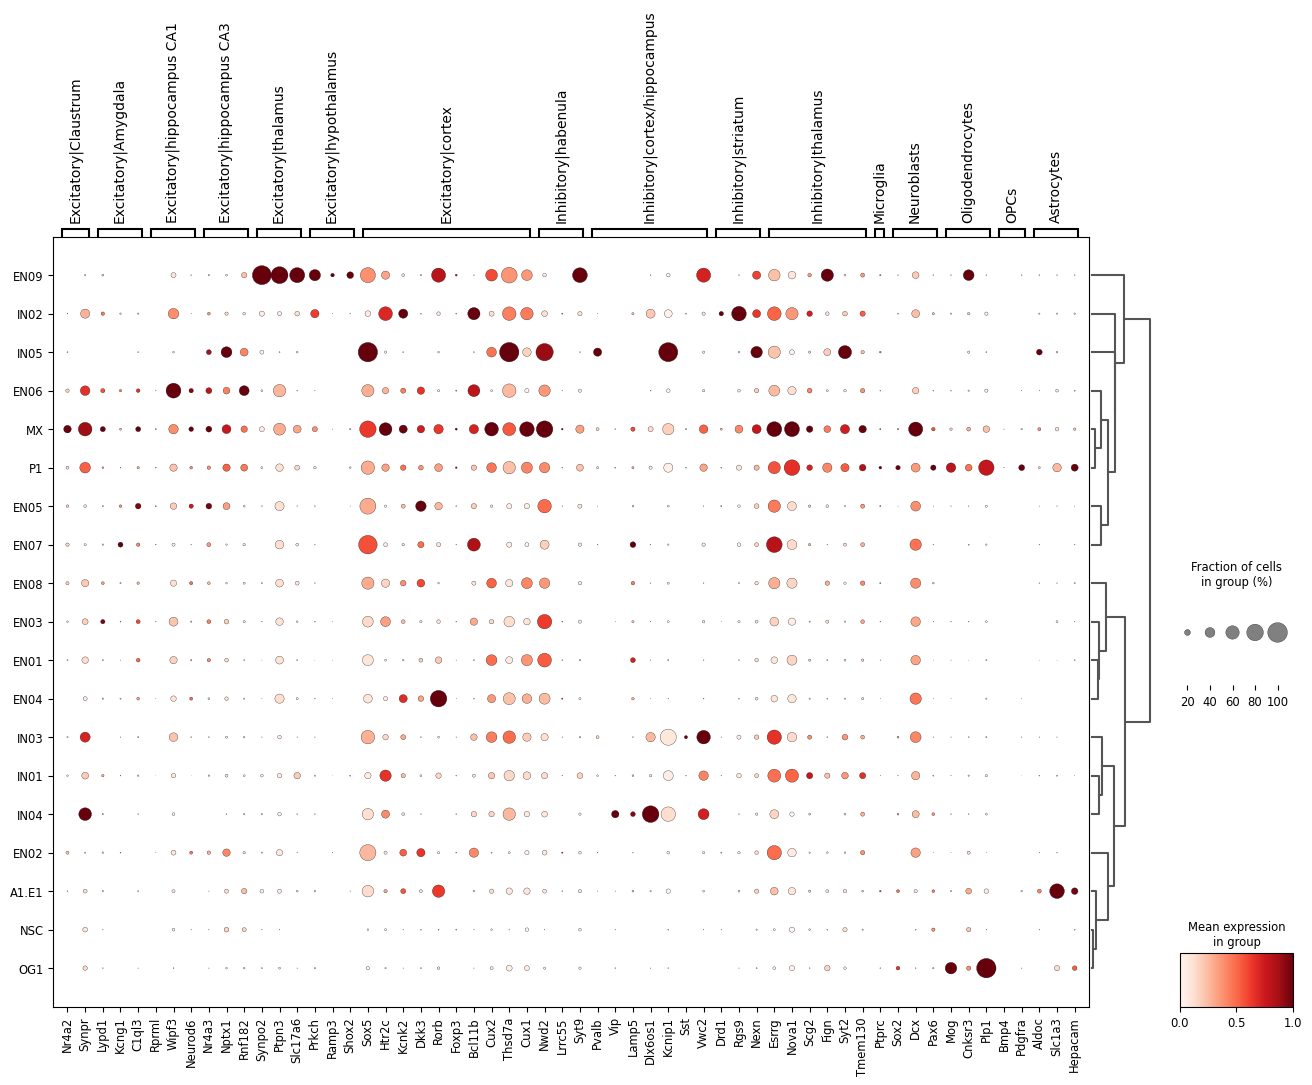

In [6]:
# Load SHARE-seq data
rna = ad.read_h5ad('data/share-seq/mouse-brain/share-seq-mouse-brain-rna-data.h5ad')
atac = ad.read_h5ad('data/share-seq/mouse-brain/share-seq-mouse-brain-atac-data.h5ad')

# Filter out unannotated & no ATAC data containing cells:
rna = rna[rna.obs['Barcode'].isin(atac.obs['rna.bc'])]
merged_obs = pd.merge(rna.obs['Barcode'],atac.obs,how='inner',left_on='Barcode',right_on='rna.bc')
merged_obs.index = pd.Index(merged_obs.index,dtype='str')
if all(rna.obs['Barcode'].reset_index(drop=True) == merged_obs['Barcode'].reset_index(drop=True)):
    rna.obs = merged_obs

rna.var_names = rna.var['Gene']
del atac

c2l_marker_genes_dict = {'Excitatory|Claustrum':['Nr4a2','Synpr'],
                         'Excitatory|Amygdala':['Lypd1','Kcng1','C1ql3'],
                         'Excitatory|hippocampus CA1':['Rprml','Wipf3','Neurod6'],
                         'Excitatory|hippocampus CA3':['Nr4a3','Nptx1','Rnf182'],
                         'Excitatory|thalamus':['Synpo2','Ptpn3','Slc17a6'],
                         'Excitatory|hypothalamus':['Prkch','Ramp3','Shox2'],
                         'Excitatory|cortex':['Sox5','Htr2c','Kcnk2','Dkk3','Rorb','Foxp3','Bcl11b','Cux2','Thsd7a','Cux1'],
                         'Inhibitory|habenula':['Nwd2','Lrrc55','Syt9'],
                         'Inhibitory|cortex/hippocampus':['Pvalb','Vip','Lamp5','Dlx6os1','Kcnip1','Sst','Vwc2'],
                         'Inhibitory|striatum':['Drd1','Rgs9','Nexn'],
                         'Inhibitory|thalamus':['Esrrg','Nova1','Scg2','Fign','Syt2','Tmem130'],
                         'Microglia':['Ptprc'],
                         'Neuroblasts':['Sox2','Dcx','Pax6'],
                         'Oligodendrocytes':['Mog','Cnksr3','Plp1'],
                         'OPCs':['Bmp4','Pdgfra'],
                         'Astrocytes':['Aldoc','Slc1a3','Hepacam']}
sc.pl.dotplot(rna,c2l_marker_genes_dict,groupby=['celltype'],dendrogram=True,figsize=(16,10),standard_scale='var')


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gene_level_alpha_hyp, gene_level_beta_hyp]
INFO:pymc:NUTS: [gene_level_alpha_hyp, gene_level_beta_hyp]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


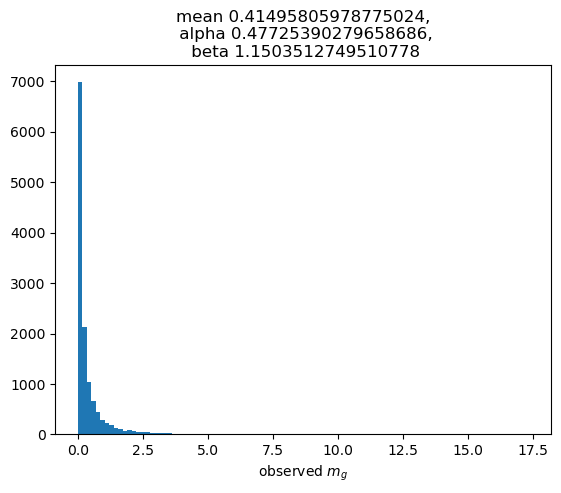

In [7]:
# put observed gene levels to data frame
gene_level_df = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['m_g'].T,
                          index=adata_vis.var.index,
                          columns=['gene_level'])

with pm.Model() as model:
    gene_level_alpha_hyp = pm.Gamma('gene_level_alpha_hyp', 1, 1, shape=(1, 1))
    gene_level_beta_hyp = pm.Gamma('gene_level_beta_hyp', 1, 1, shape=(1, 1))
    # global gene levels
    gene_level = pm.Gamma('gene_level', gene_level_alpha_hyp,
                          gene_level_beta_hyp, shape=(gene_level_df.shape[0], 1),
                          observed=gene_level_df.values)
    
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)
    

plt.hist(gene_level_df.values.flatten(), bins=100);
plt.xlabel(r'observed $m_g$')
plt.title(f'mean {gene_level_df.values.mean()},\n alpha {posterior.posterior.gene_level_alpha_hyp.mean()},\n beta {posterior.posterior.gene_level_beta_hyp.mean()}');


In [8]:
# Could determine class matches based on gene expression if necessary:
# class_matches ={'EN09':'Ext_Thal_1','IN02':'Inh_Meis2_1',} ...

In [9]:
rna.obs['celltype'].value_counts()

IN01     591
EN01     327
EN02     239
EN03     235
EN04     216
EN05     191
MX       185
IN02     182
P1       153
A1.E1    137
EN06     132
OG1      130
IN03     113
NSC      106
EN07      93
EN08      79
EN09      67
IN04      66
IN05      51
Name: celltype, dtype: int64

In [10]:
# Generate training - test split... Do we need to?

In [11]:
## simulation settings
np.random.seed(seed)

## generate per cell type simulation attributes
n_cell_types = rna.obs['celltype'].value_counts().shape[0]
n_sparse = n_cell_types - n_uniform
n_zones_per_cell_type = np.random.binomial(n_tissue_zones, 0.02, size=n_sparse)+1
experiment_id = np.repeat(np.arange(n_experiments), np.prod(n_locations))
cell_types = np.array(rna.obs['celltype'].unique())
uniform_cell_types = np.random.choice(cell_types, n_uniform, replace=False)
sparse_cell_types = cell_types[~np.isin(cell_types, uniform_cell_types)]

# generate matrix of which cell types are in which zones
cell_types2zones = pd.DataFrame(0, index=cell_types, 
                                columns=[f'tissue_zone_{i}' for i in range(n_tissue_zones)] \
                                + [f'uniform_{i}' for i in range(n_uniform)])
for i, n in enumerate(n_zones_per_cell_type):
    pos = np.random.randint(n_tissue_zones, size=n)
    cell_types2zones.iloc[i,pos] = 1
    
# and which uniform cell types belong to which uniform pattern
for i in range(n_uniform):
    cell_types2zones.iloc[n_sparse+i, n_tissue_zones+i] = 1
    
cell_types2zones.sum(), cell_types2zones.sum(1)

(tissue_zone_0    2
 tissue_zone_1    2
 tissue_zone_2    1
 tissue_zone_3    1
 tissue_zone_4    1
 tissue_zone_5    3
 tissue_zone_6    2
 tissue_zone_7    1
 tissue_zone_8    2
 tissue_zone_9    2
 uniform_0        1
 uniform_1        1
 uniform_2        1
 uniform_3        1
 uniform_4        1
 uniform_5        1
 dtype: int64,
 EN07     1
 P1       1
 IN01     2
 EN02     1
 IN02     2
 EN01     1
 MX       1
 IN05     1
 EN06     2
 EN03     2
 EN04     1
 EN05     1
 OG1      1
 EN08     1
 IN03     1
 EN09     1
 IN04     1
 NSC      1
 A1.E1    1
 dtype: int64)

In [12]:
np.random.seed(seed)
# Assign cell types to either high or low density, balanced by uniform / tissue zone
high_density_cell_types = list(np.random.choice(uniform_cell_types, 
                                                int(np.round(n_uniform * p_high_density)), 
                                                replace=False))
for z, n in cell_types2zones.sum().items():
    
    ct = list(np.random.choice(cell_types2zones.index[cell_types2zones[z] > 0], 
                                                int(np.round(n * p_high_density)), 
                                                replace=False))
    print(ct)
    high_density_cell_types = high_density_cell_types + ct
    
low_density_cell_types = cell_types[~np.isin(cell_types, high_density_cell_types)]
    
# what proportion of cells are uniform?
len(high_density_cell_types) / len(cell_types)

['P1']
['OG1']
[]
[]
[]
['EN06']
['EN03']
[]
['MX']
['EN04']
[]
[]
[]
[]
[]
[]


0.42105263157894735

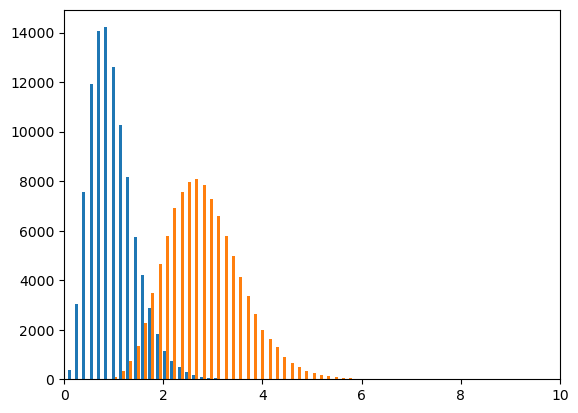

In [13]:
np.random.seed(seed)
#Generate average abundance for low and high density cell types
mean_var_ratio = 5
plt.hist([np.random.gamma(mu_low_density * mean_var_ratio, 1/mean_var_ratio, size=int(1e5)),
          np.random.gamma(mu_high_density * mean_var_ratio, 1/mean_var_ratio, size=int(1e5))], bins=50);
plt.xlim(0, 10);

cell_types2zones.loc[low_density_cell_types] = cell_types2zones.loc[low_density_cell_types] \
 * np.random.gamma(mu_low_density * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(low_density_cell_types), 1))

cell_types2zones.loc[high_density_cell_types] = cell_types2zones.loc[high_density_cell_types] \
 * np.random.gamma(mu_high_density * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(high_density_cell_types), 1))

In [14]:
cell_types2zones

tissue_zone_0  tissue_zone_1  tissue_zone_2  tissue_zone_3  \
EN07        0.000000       0.000000       0.000000       0.000000   
P1          4.359060       0.000000       0.000000       0.000000   
IN01        0.000000       0.000000       0.000000       0.000000   
EN02        0.000000       0.000000       0.000000       0.000000   
IN02        2.649399       0.000000       0.000000       0.000000   
EN01        0.000000       1.276274       0.000000       0.000000   
MX          0.000000       0.000000       0.000000       0.000000   
IN05        0.000000       0.000000       0.000000       0.000000   
EN06        0.000000       0.000000       0.000000       0.000000   
EN03        0.000000       0.000000       4.007375       0.000000   
EN04        0.000000       0.000000       0.000000       0.000000   
EN05        0.000000       0.000000       0.000000       0.528672   
OG1         0.000000       1.870802       0.000000       0.000000   
EN08        0.000000       0.000000       0.000000       0.000000   
IN03        0.000000       0.000000       0.000000       0.000000   
EN09        0.000000       0.000000       0.000000       0.000000   
IN04        0.000000       0.000000       0.000000       0.000000   
NSC         0.000000       0.000000       0.000000       0.000000   
A1.E1       0.000000       0.000000       0.000000       0.000000   

       tissue_zone_4  tissue_zone_5  tissue_zone_6  tissue_zone_7  \
EN07        0.000000       1.089940       0.000000       0.000000   
P1          0.000000       0.000000       0.000000       0.000000   
IN01        0.000000       0.000000       0.000000       0.677649   
EN02        0.000000       0.000000       0.000000       0.000000   
IN02        0.000000       2.649399       0.000000       0.000000   
EN01        0.000000       0.000000       0.000000       0.000000   
MX          0.000000       0.000000       0.000000       0.000000   
IN05        0.000000       0.000000       1.214465       0.000000   
EN06        2.112521       2.112521       0.000000       0.000000   
EN03        0.000000       0.000000       4.007375       0.000000   
EN04        0.000000       0.000000       0.000000       0.000000   
EN05        0.000000       0.000000       0.000000       0.000000   
OG1         0.000000       0.000000       0.000000       0.000000   
EN08        0.000000       0.000000       0.000000       0.000000   
IN03        0.000000       0.000000       0.000000       0.000000   
EN09        0.000000       0.000000       0.000000       0.000000   
IN04        0.000000       0.000000       0.000000       0.000000   
NSC         0.000000       0.000000       0.000000       0.000000   
A1.E1       0.000000       0.000000       0.000000       0.000000   

       tissue_zone_8  tissue_zone_9  uniform_0  uniform_1  uniform_2  \
EN07        0.000000       0.000000   0.000000   0.000000   0.000000   
P1          0.000000       0.000000   0.000000   0.000000   0.000000   
IN01        0.000000       0.677649   0.000000   0.000000   0.000000   
EN02        0.379940       0.000000   0.000000   0.000000   0.000000   
IN02        0.000000       0.000000   0.000000   0.000000   0.000000   
EN01        0.000000       0.000000   0.000000   0.000000   0.000000   
MX          1.207372       0.000000   0.000000   0.000000   0.000000   
IN05        0.000000       0.000000   0.000000   0.000000   0.000000   
EN06        0.000000       0.000000   0.000000   0.000000   0.000000   
EN03        0.000000       0.000000   0.000000   0.000000   0.000000   
EN04        0.000000       3.909571   0.000000   0.000000   0.000000   
EN05        0.000000       0.000000   0.000000   0.000000   0.000000   
OG1         0.000000       0.000000   0.000000   0.000000   0.000000   
EN08        0.000000       0.000000   0.164311   0.000000   0.000000   
IN03        0.000000       0.000000   0.000000   0.795787   0.000000   
EN09        0.000000       0.000000   0.000000   0.000000   1.352191   
IN04        0.000000 

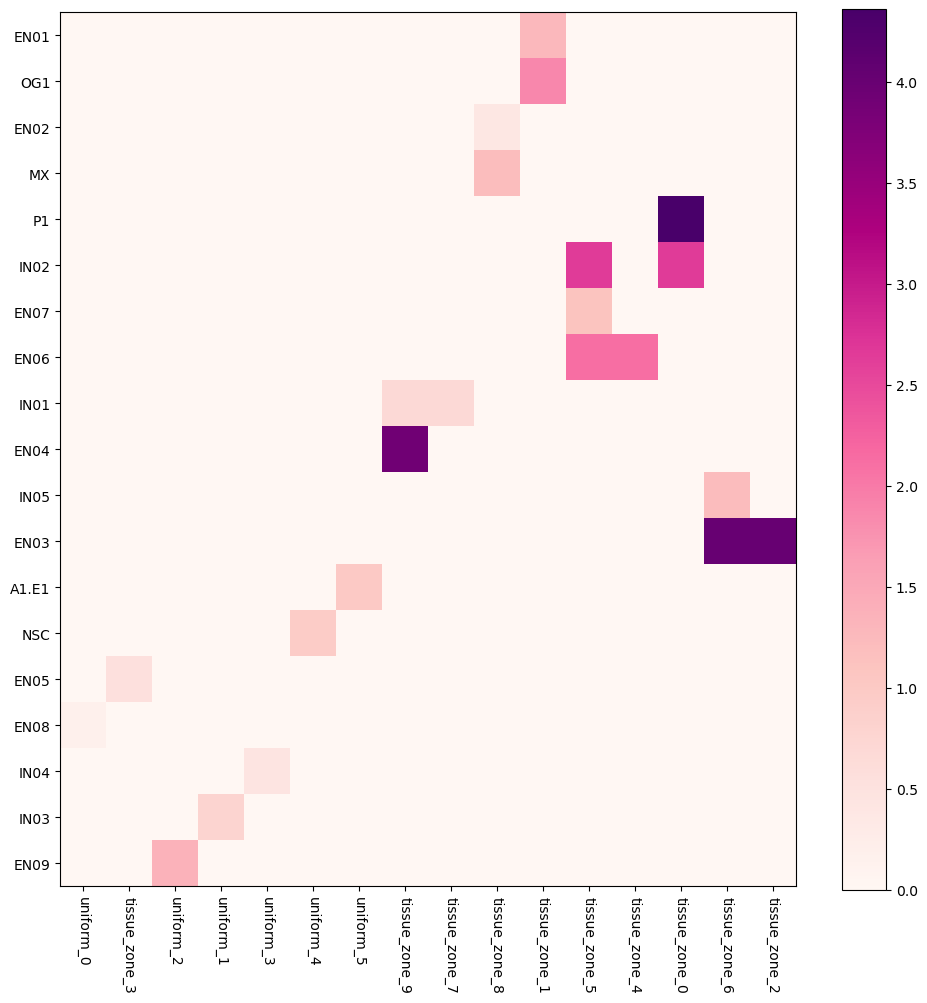

In [15]:
from cell2location.plt.plot_heatmap import clustermap
clustermap(cell_types2zones, figure_size=[10, 10])

In [16]:
def kernel(X1, X2, l=1.0, eta=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return eta**2 * np.exp(-0.5 / l**2 * sqdist)
    
def generate_grid(
              n=[50, 50] #spatial dimensions 
):
    n1, n2 = n 
    x1 = np.linspace(0, 100, n1)[:,None] #saptial dimensions 
    x2 = np.linspace(0, 100, n2)[:,None] #saptial dimensions 

    # make cartesian grid out of each dimension x1 and x2
    return pm.math.cartesian(x1[:,None], x2[:,None]), x1, x2

def random_GP(X, x1=1, x2=1, #coordinates
              n_variables = 5, #zones
              eta_true = 5, #variance, defines overlapping
              l1_true=[8, 10, 15], #bw parameter
              l2_true=[8, 10, 15]
             ):

    #cov1, cov2 = kernel(x1, x1, l=l1_true), kernel(x2, x2, l=l2_true)
    K = [np.kron(kernel(x1, x1, l=l1_true[i], eta=eta_true), 
                 kernel(x2, x2, l=l2_true[i], eta=eta_true)) 
         for i in range(n_variables)]

    gaus_true = np.stack([np.random.multivariate_normal(np.zeros(X.shape[0]), 
                                                        2*K[i]) 
                          for i in range(n_variables)]).T #samples from GP
    N_true = (np.exp(gaus_true).T / np.exp(gaus_true).sum(axis=1)).T #softmax transform 
    return N_true


def plot_spatial(values, n=[50,50], nrows=5, names=['cell type'],
                 vmin=0, vmax=1):
    
    n_cell_types = values.shape[1]
    n1, n2 = n 
    ncols = int(np.ceil((n_cell_types+1) / nrows))
    for ct in range(n_cell_types):
        plt.subplot(nrows, ncols, ct+1)
        plt.imshow(values[:,ct].reshape(n1,n2).T, 
                   cmap=plt.cm.get_cmap('magma'),
                   vmin=vmin, vmax=vmax
                  )
        plt.colorbar()
        if len(names) > 1:
            plt.title(names[ct])
        else:
            plt.title(f'{names[0]} {ct+1}')

    plt.subplot(nrows, ncols, n_cell_types+1) 
    plt.imshow(values.sum(axis=1).reshape(n1,n2).T, 
               cmap=plt.cm.get_cmap('Greys'))
    plt.colorbar()
    plt.title('total')

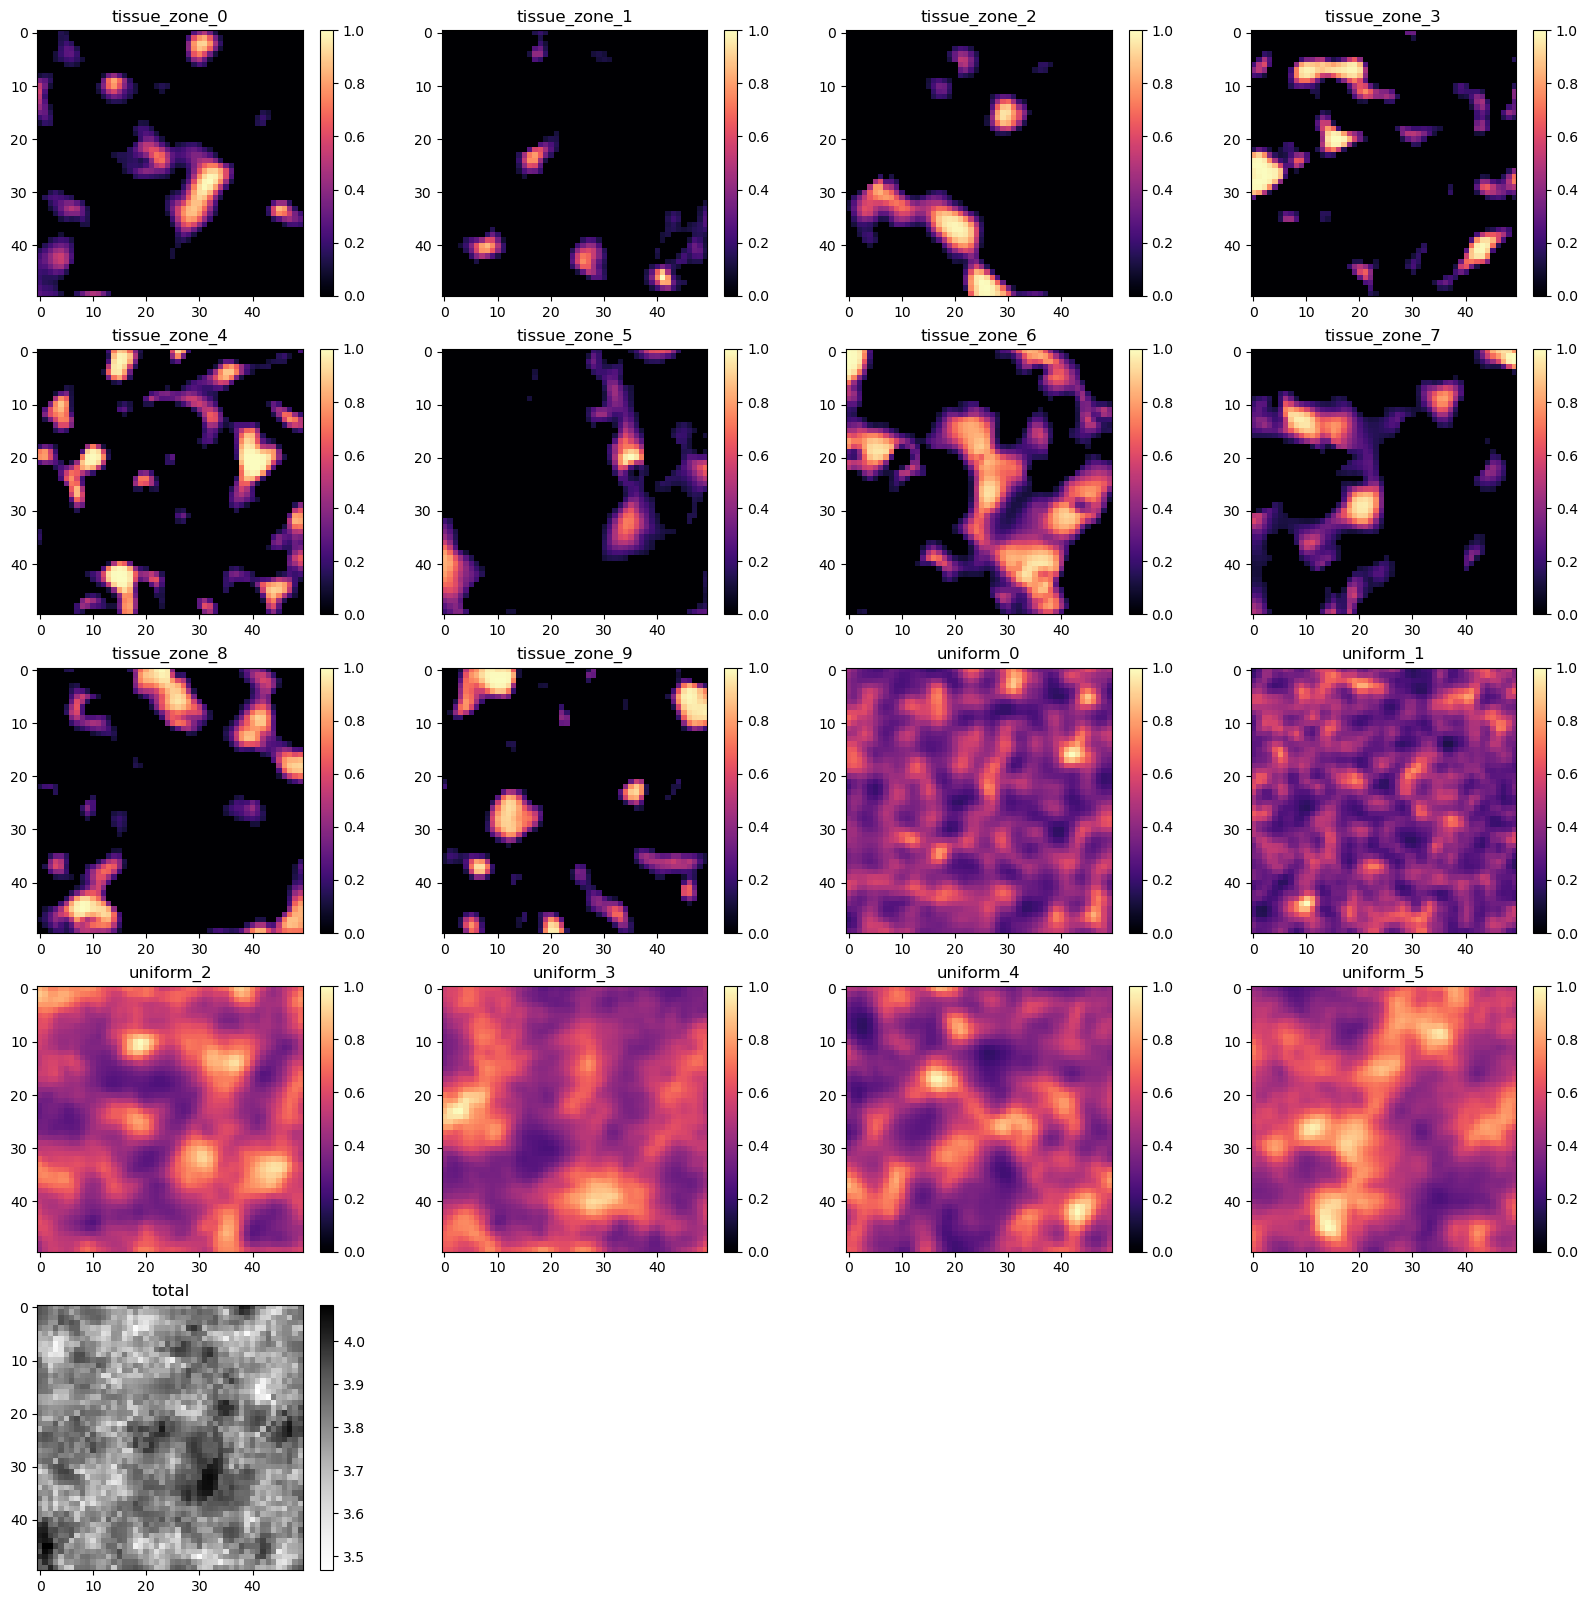

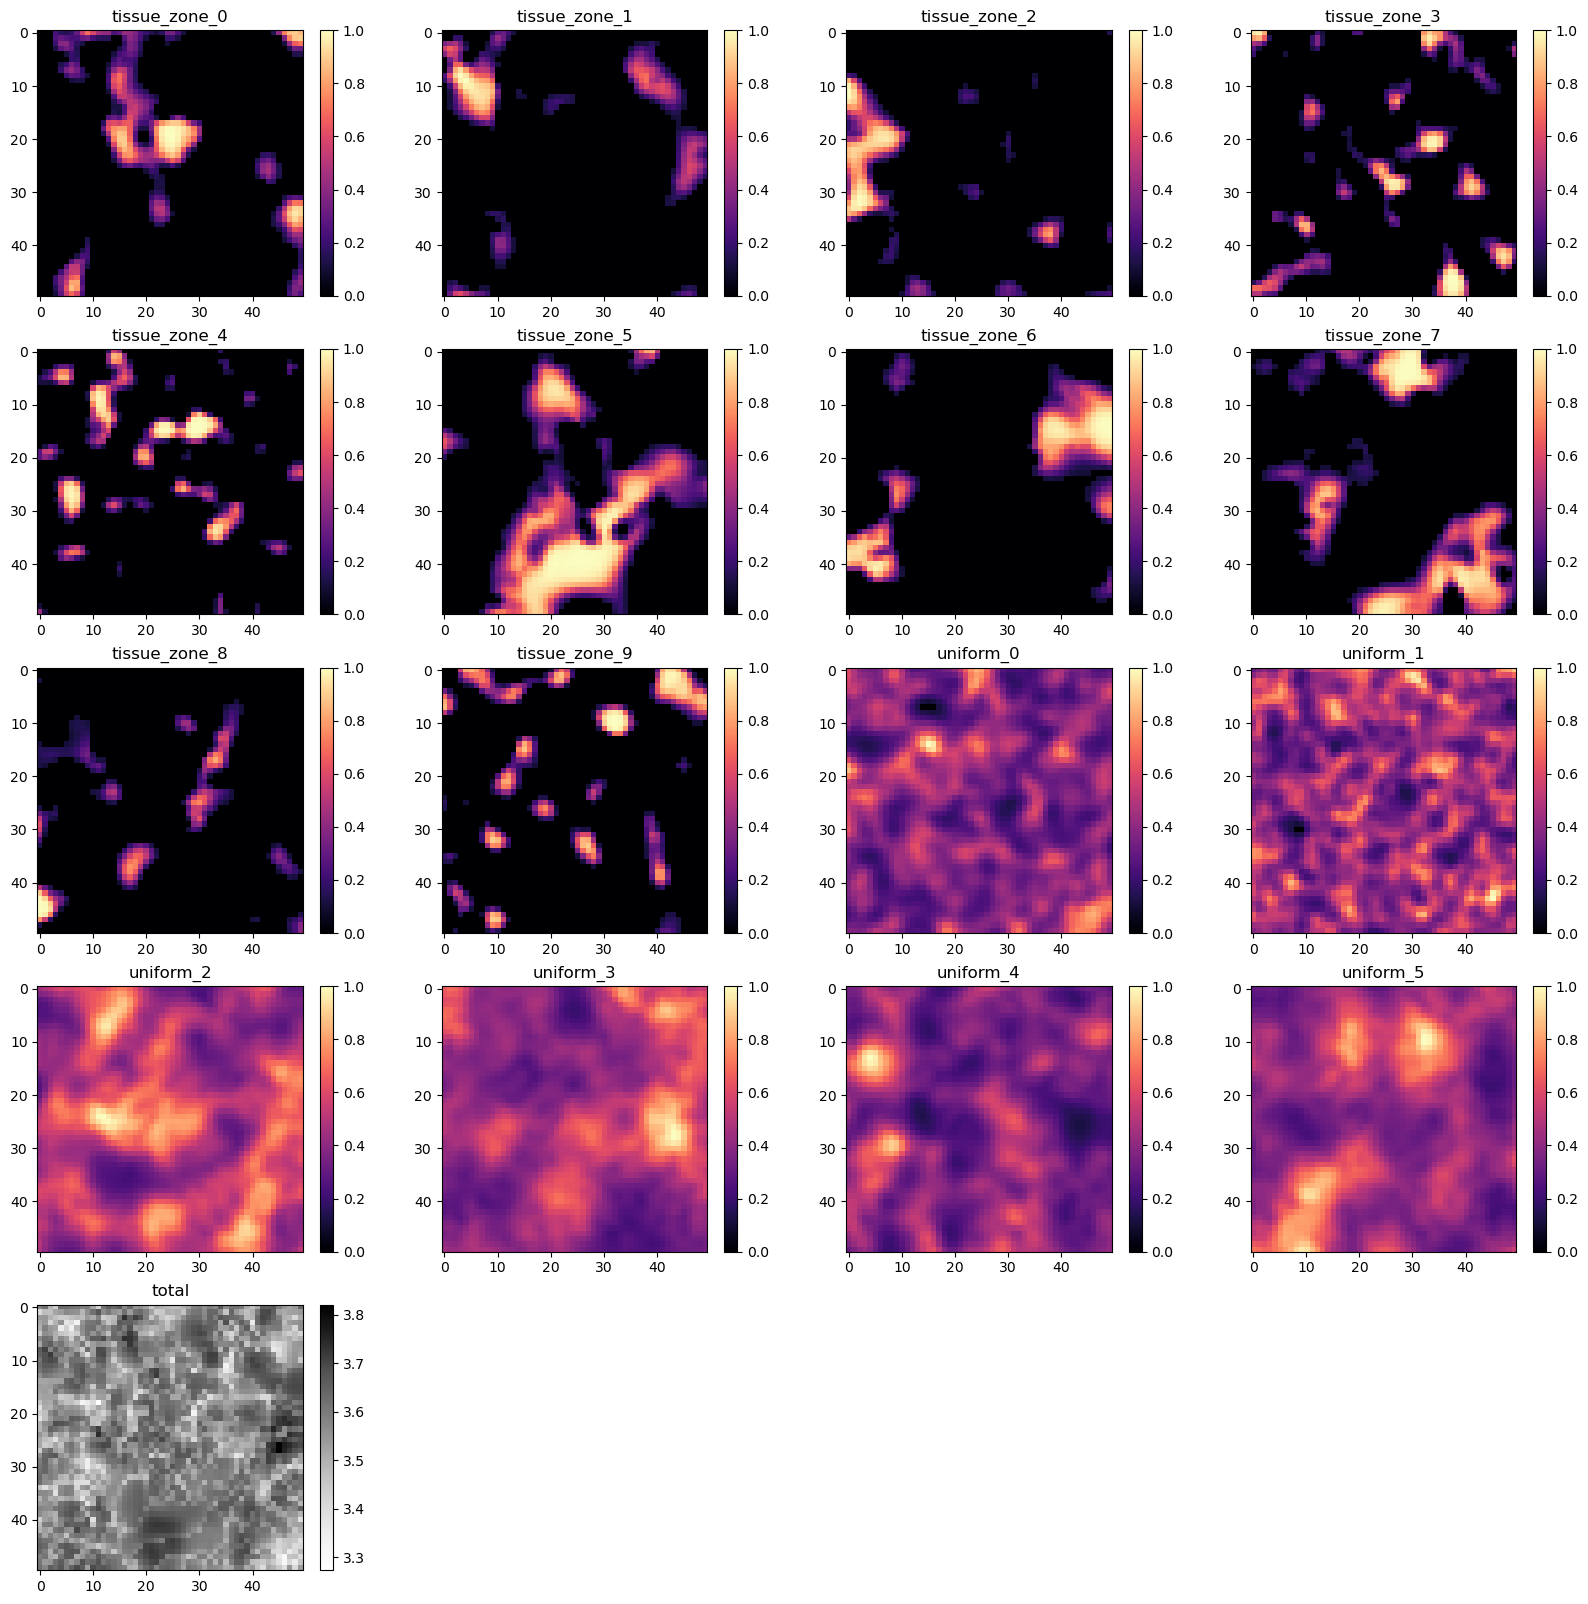

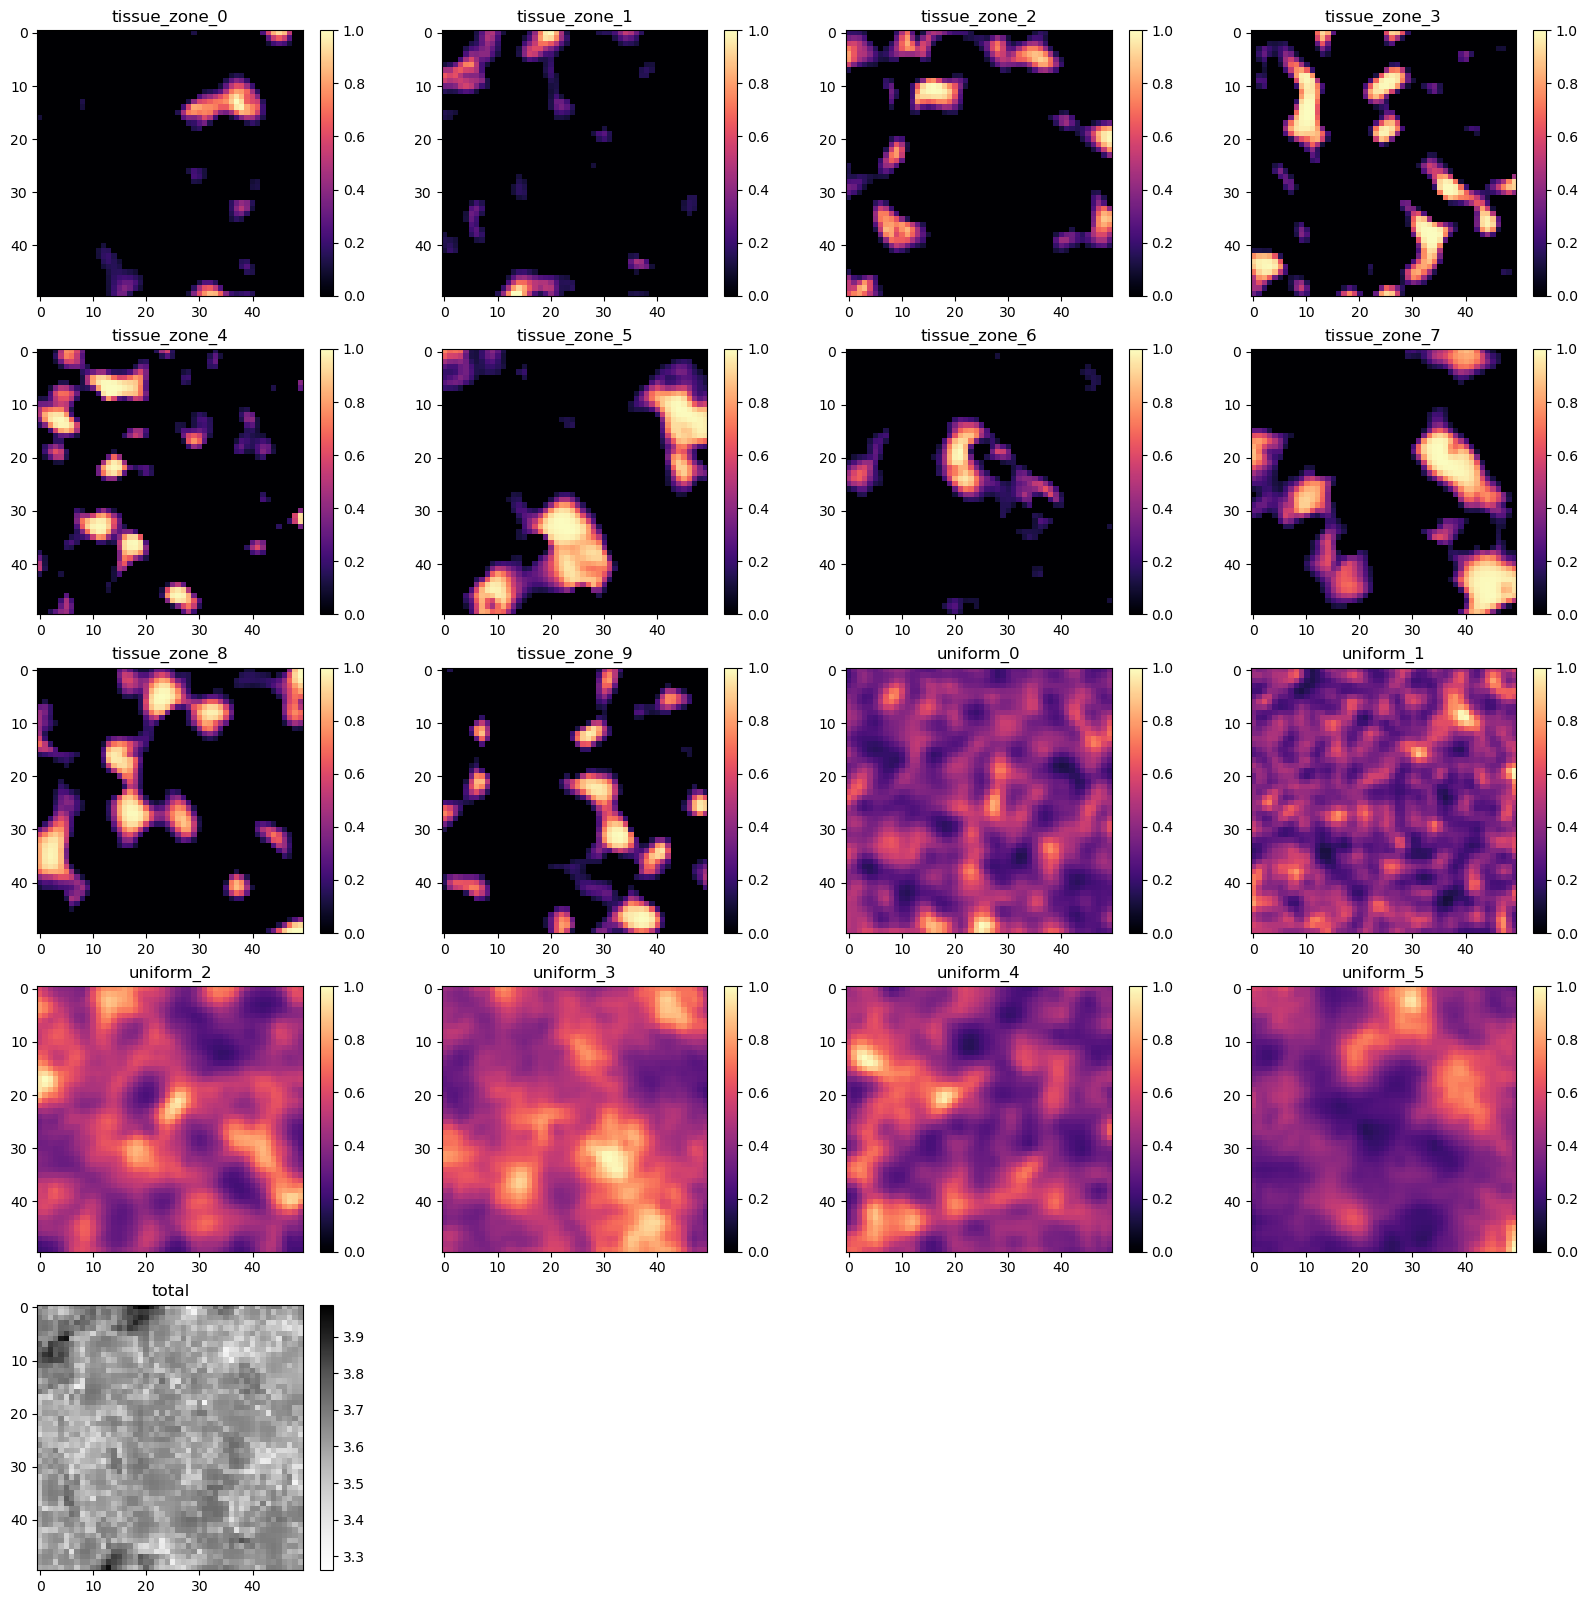

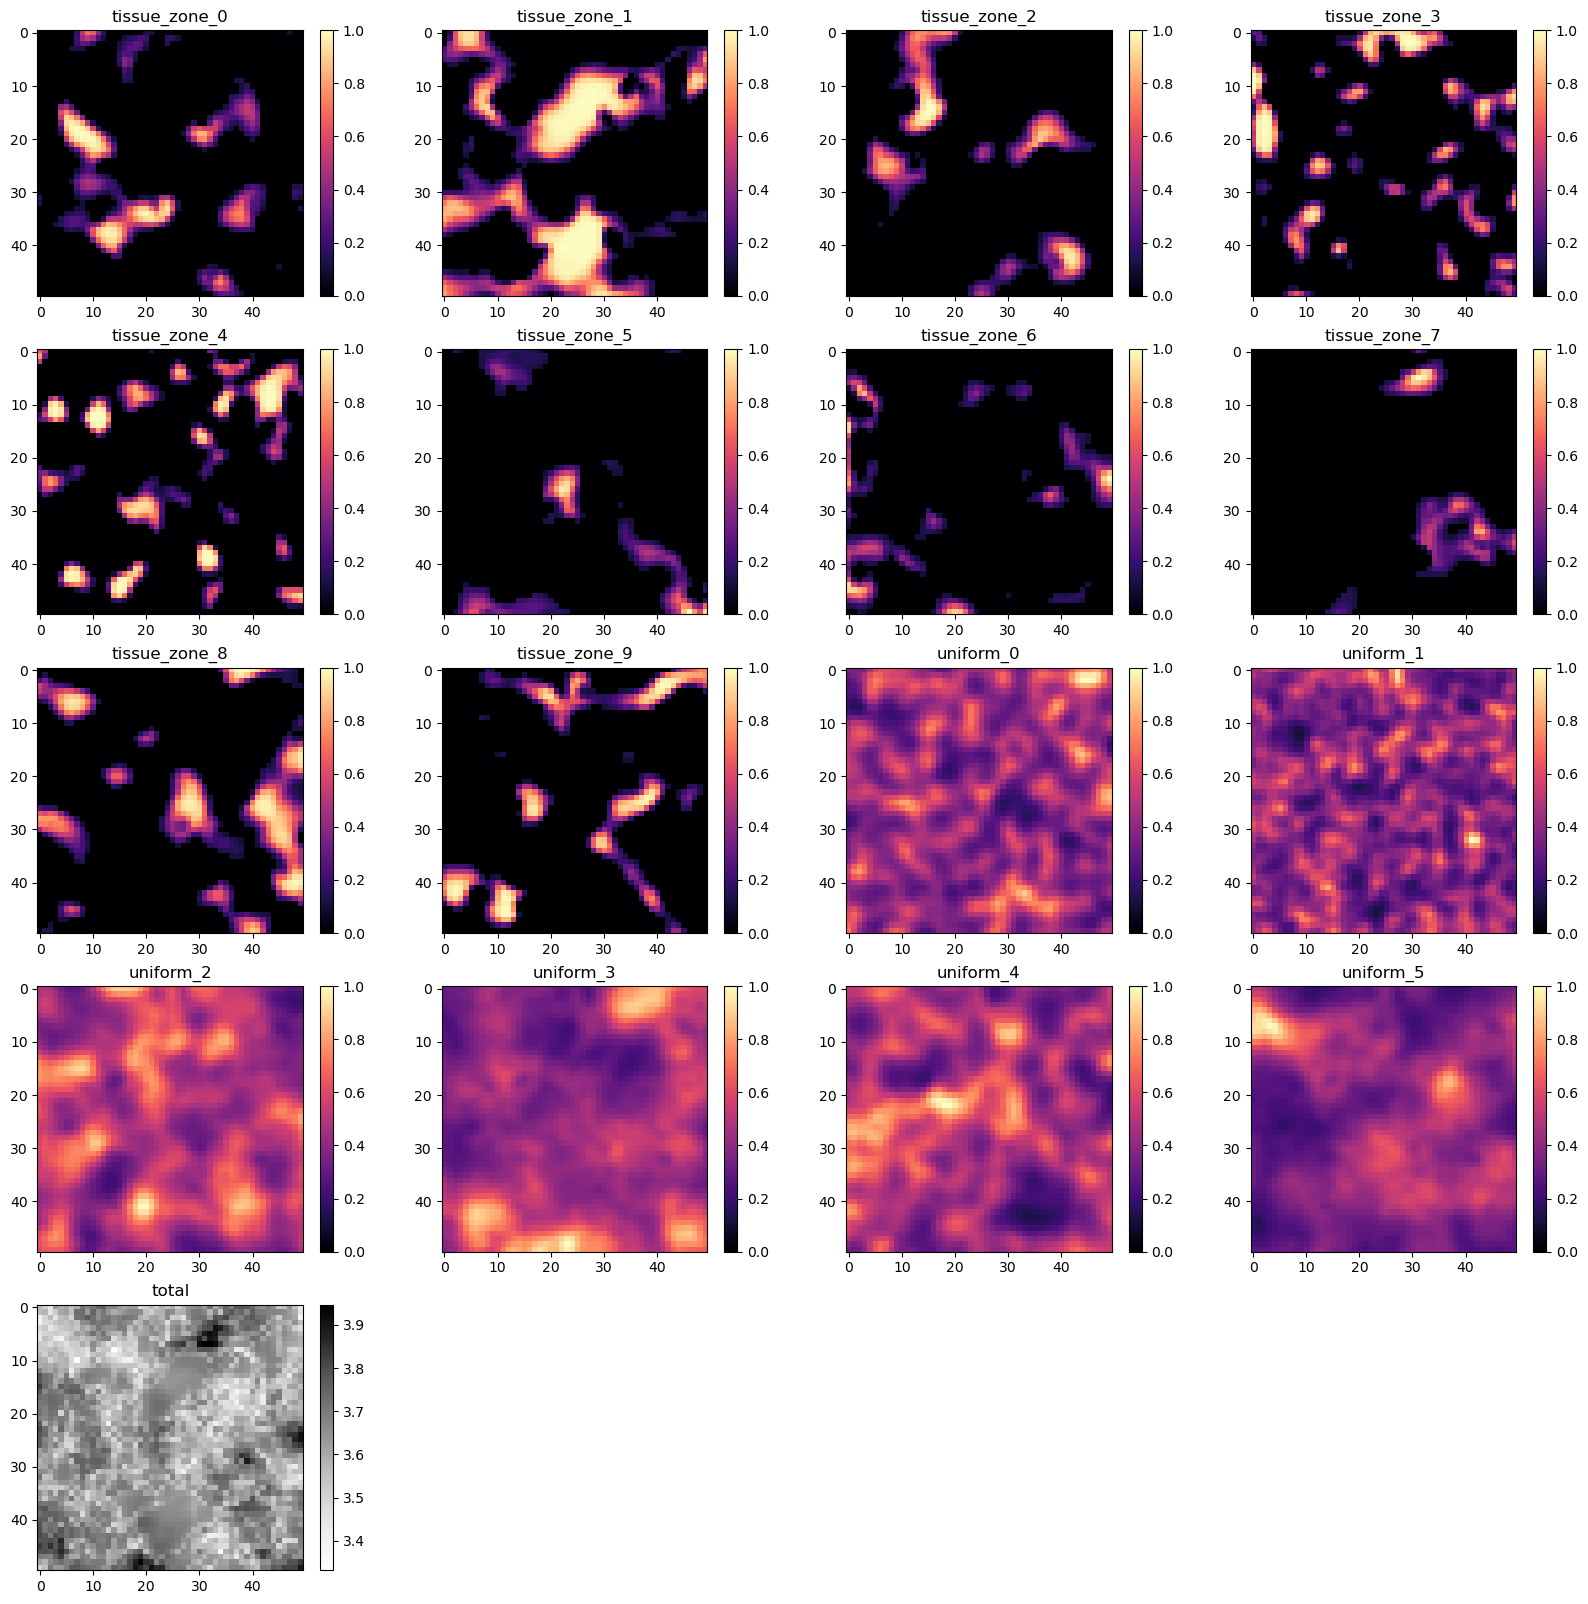

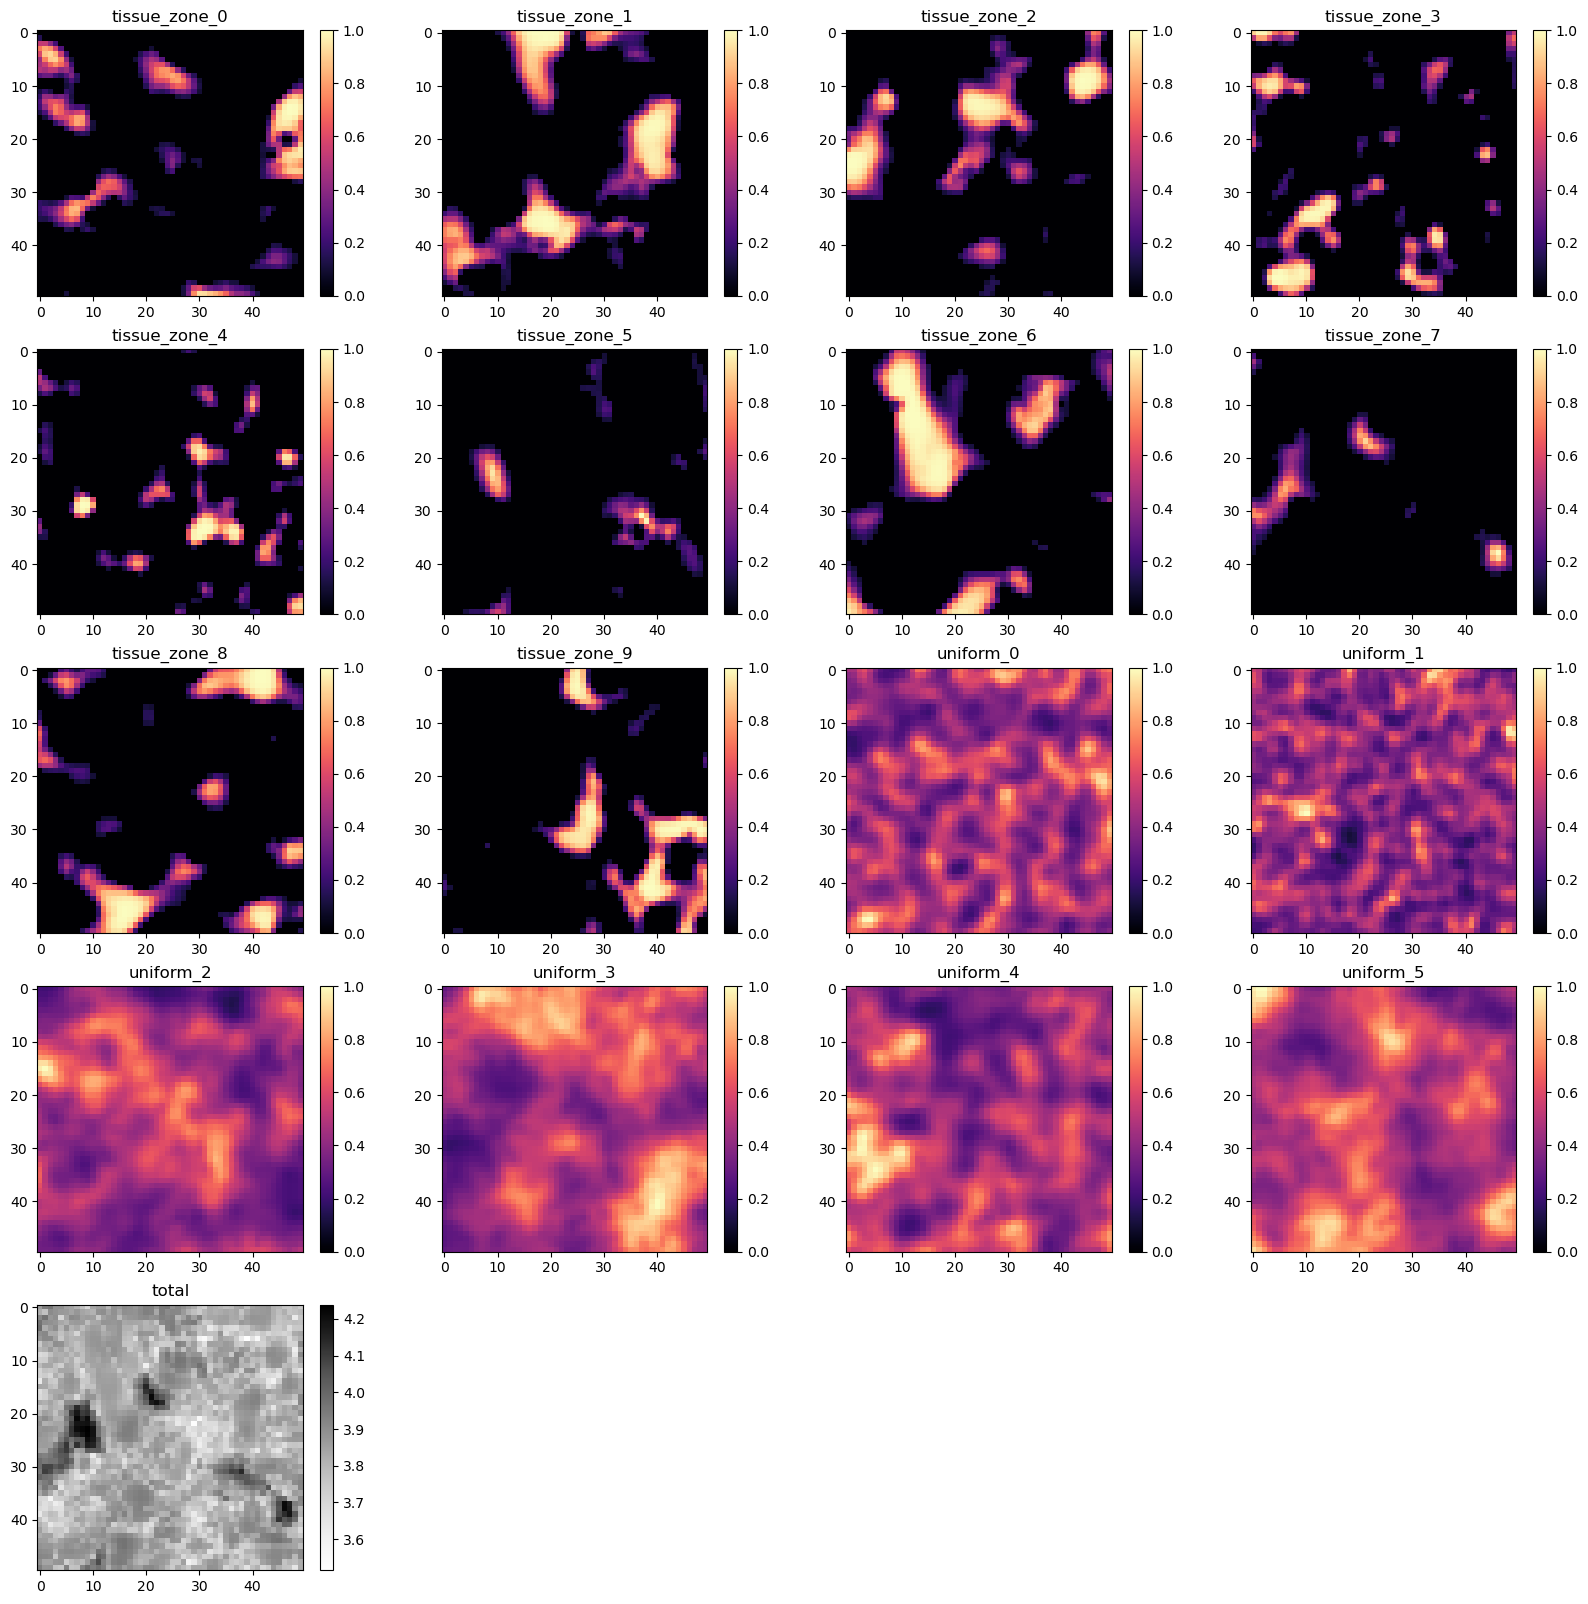

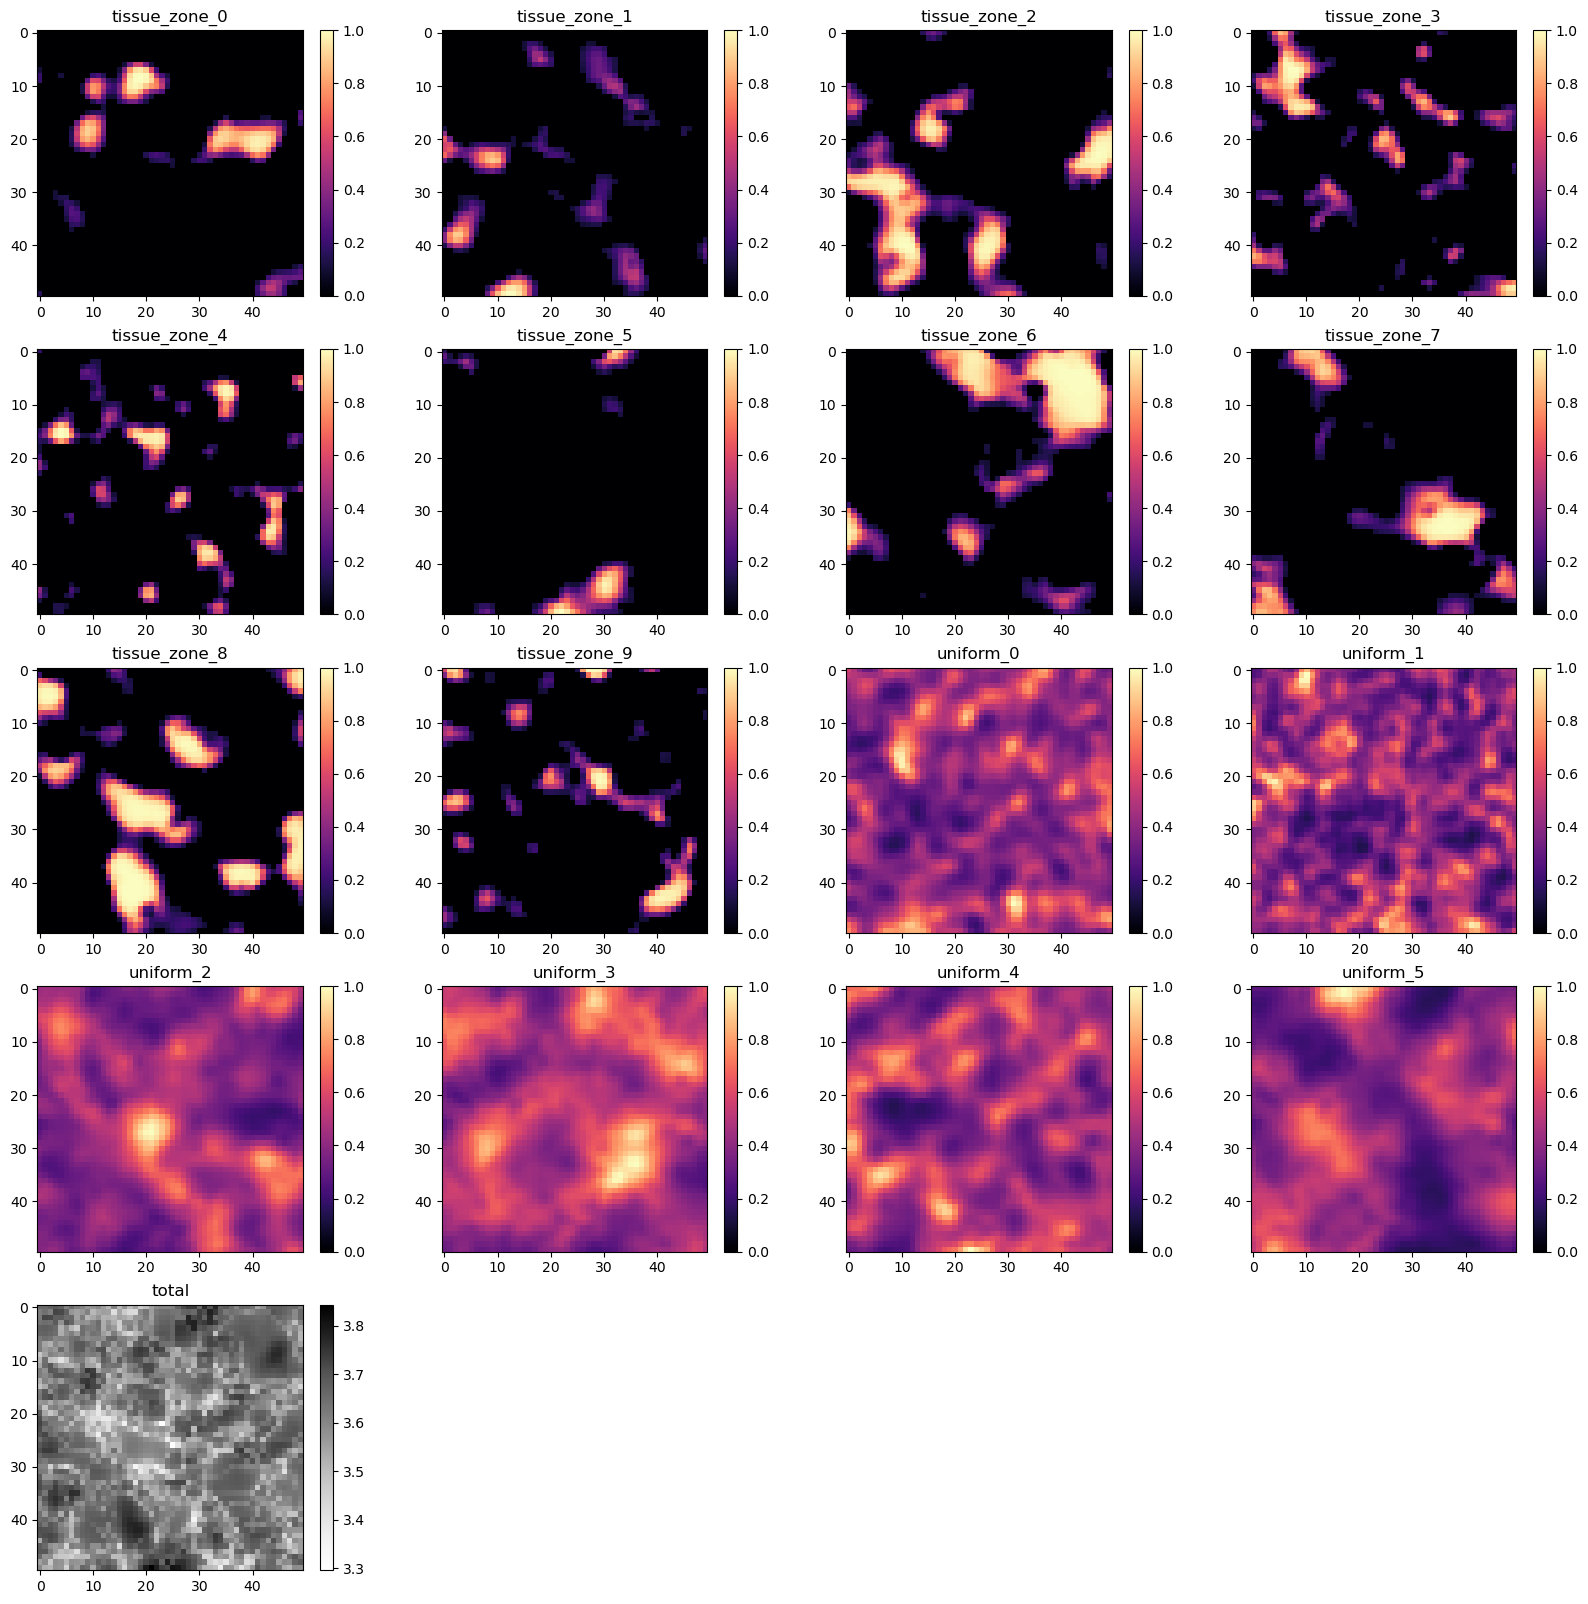

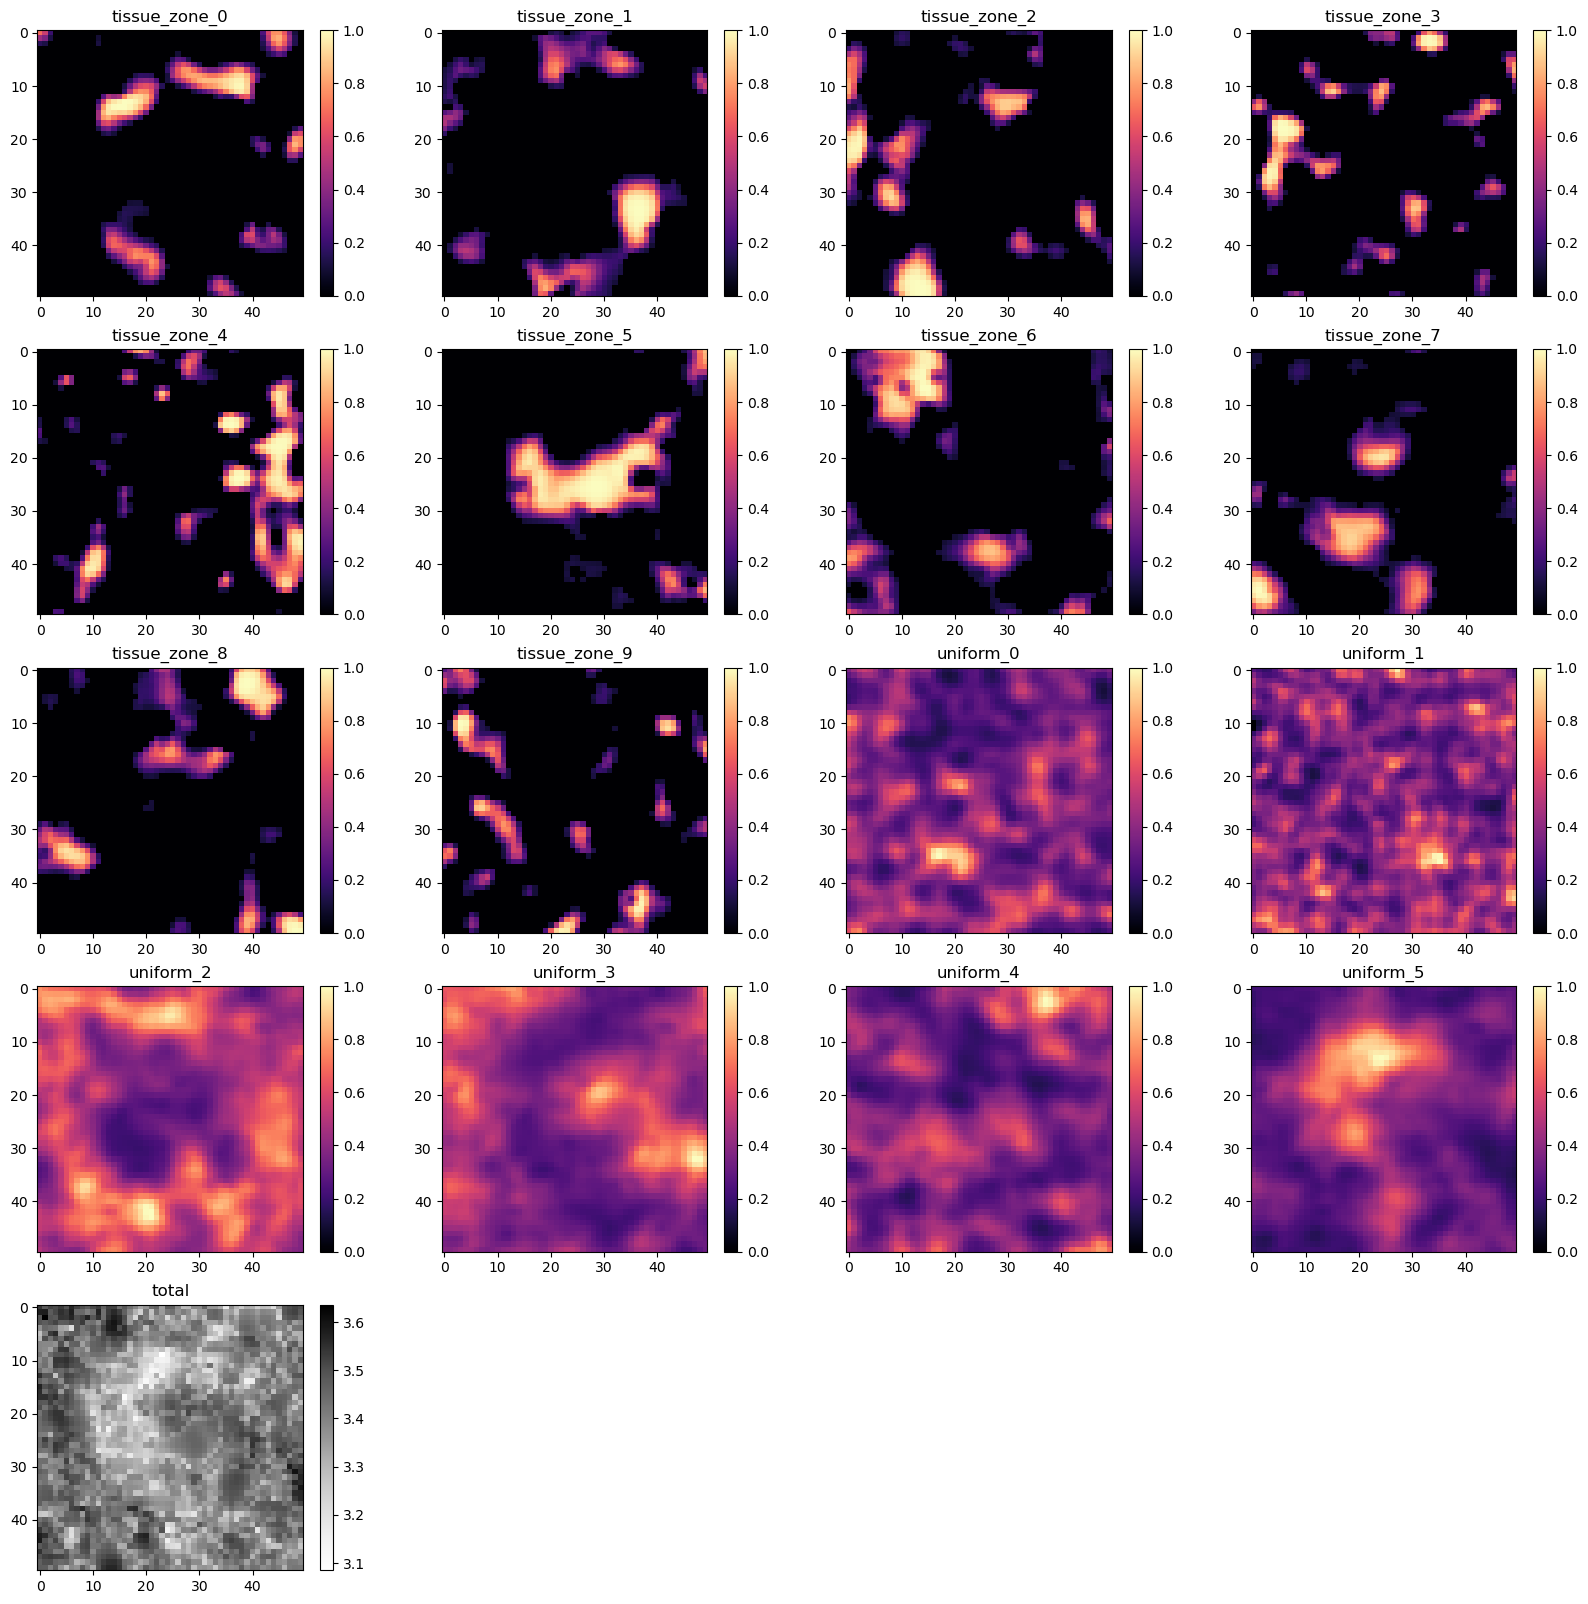

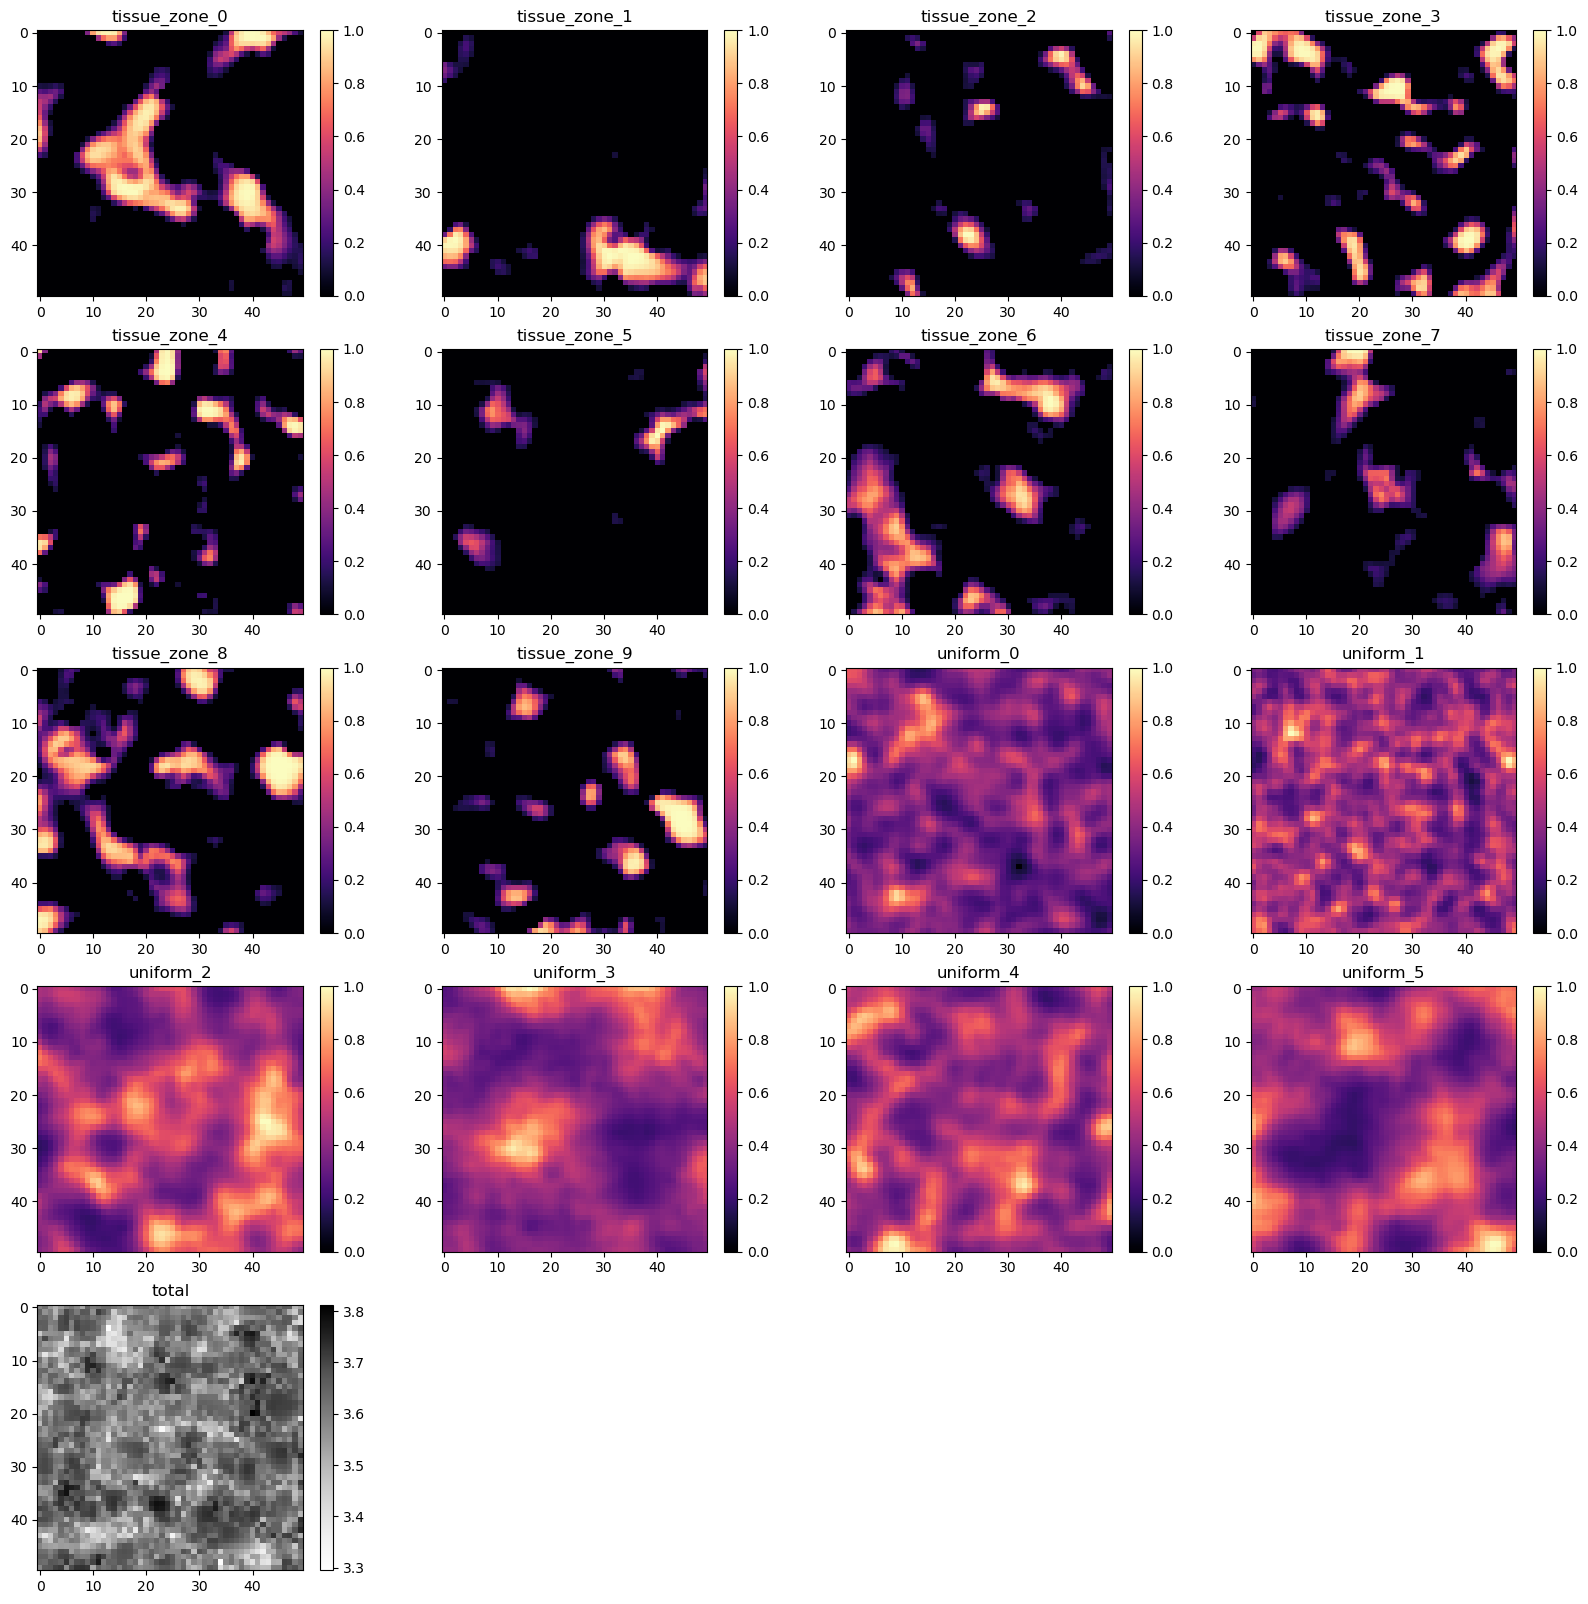

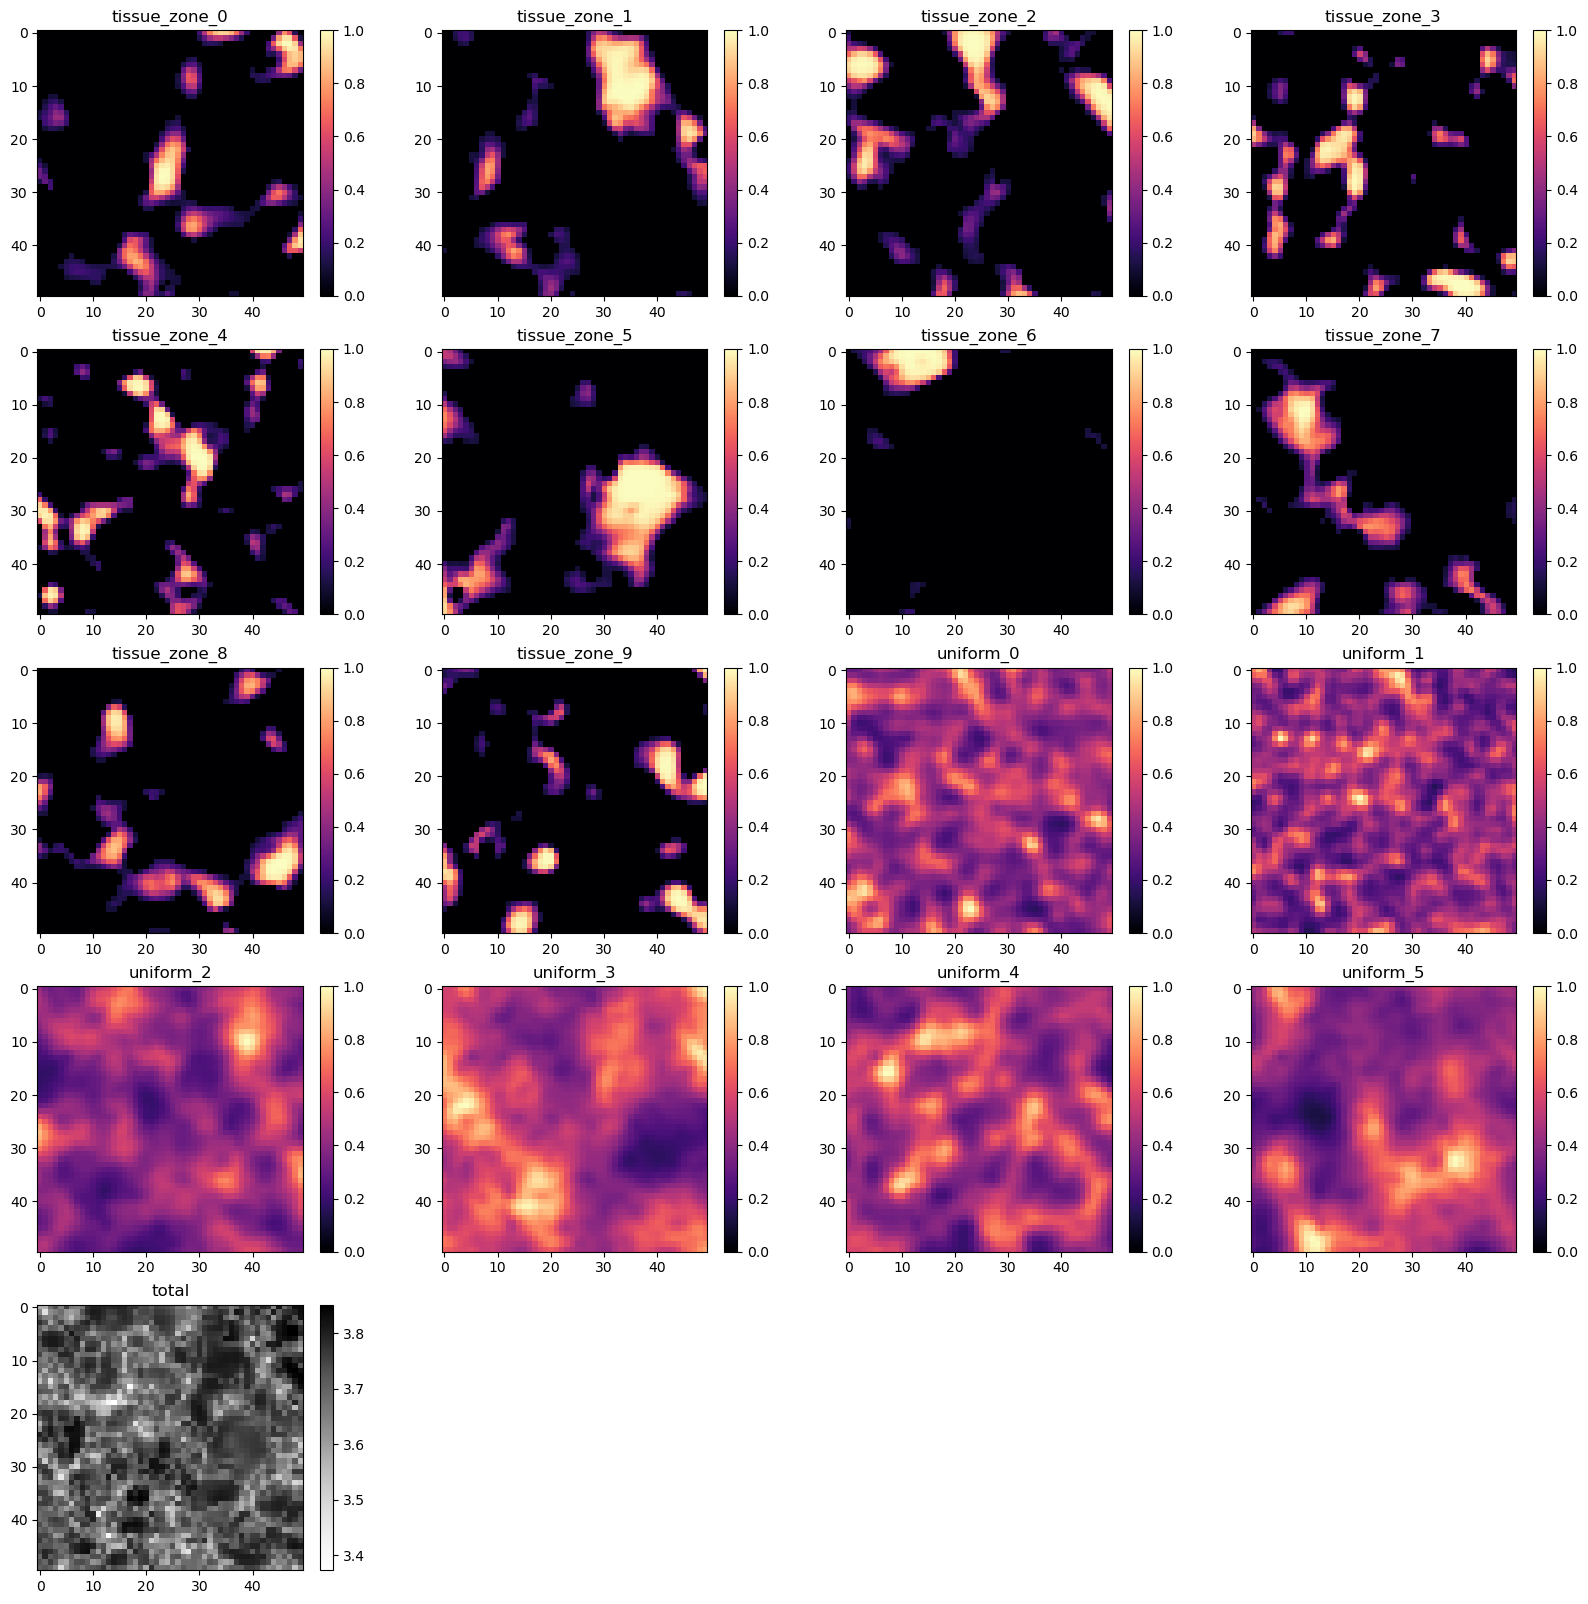

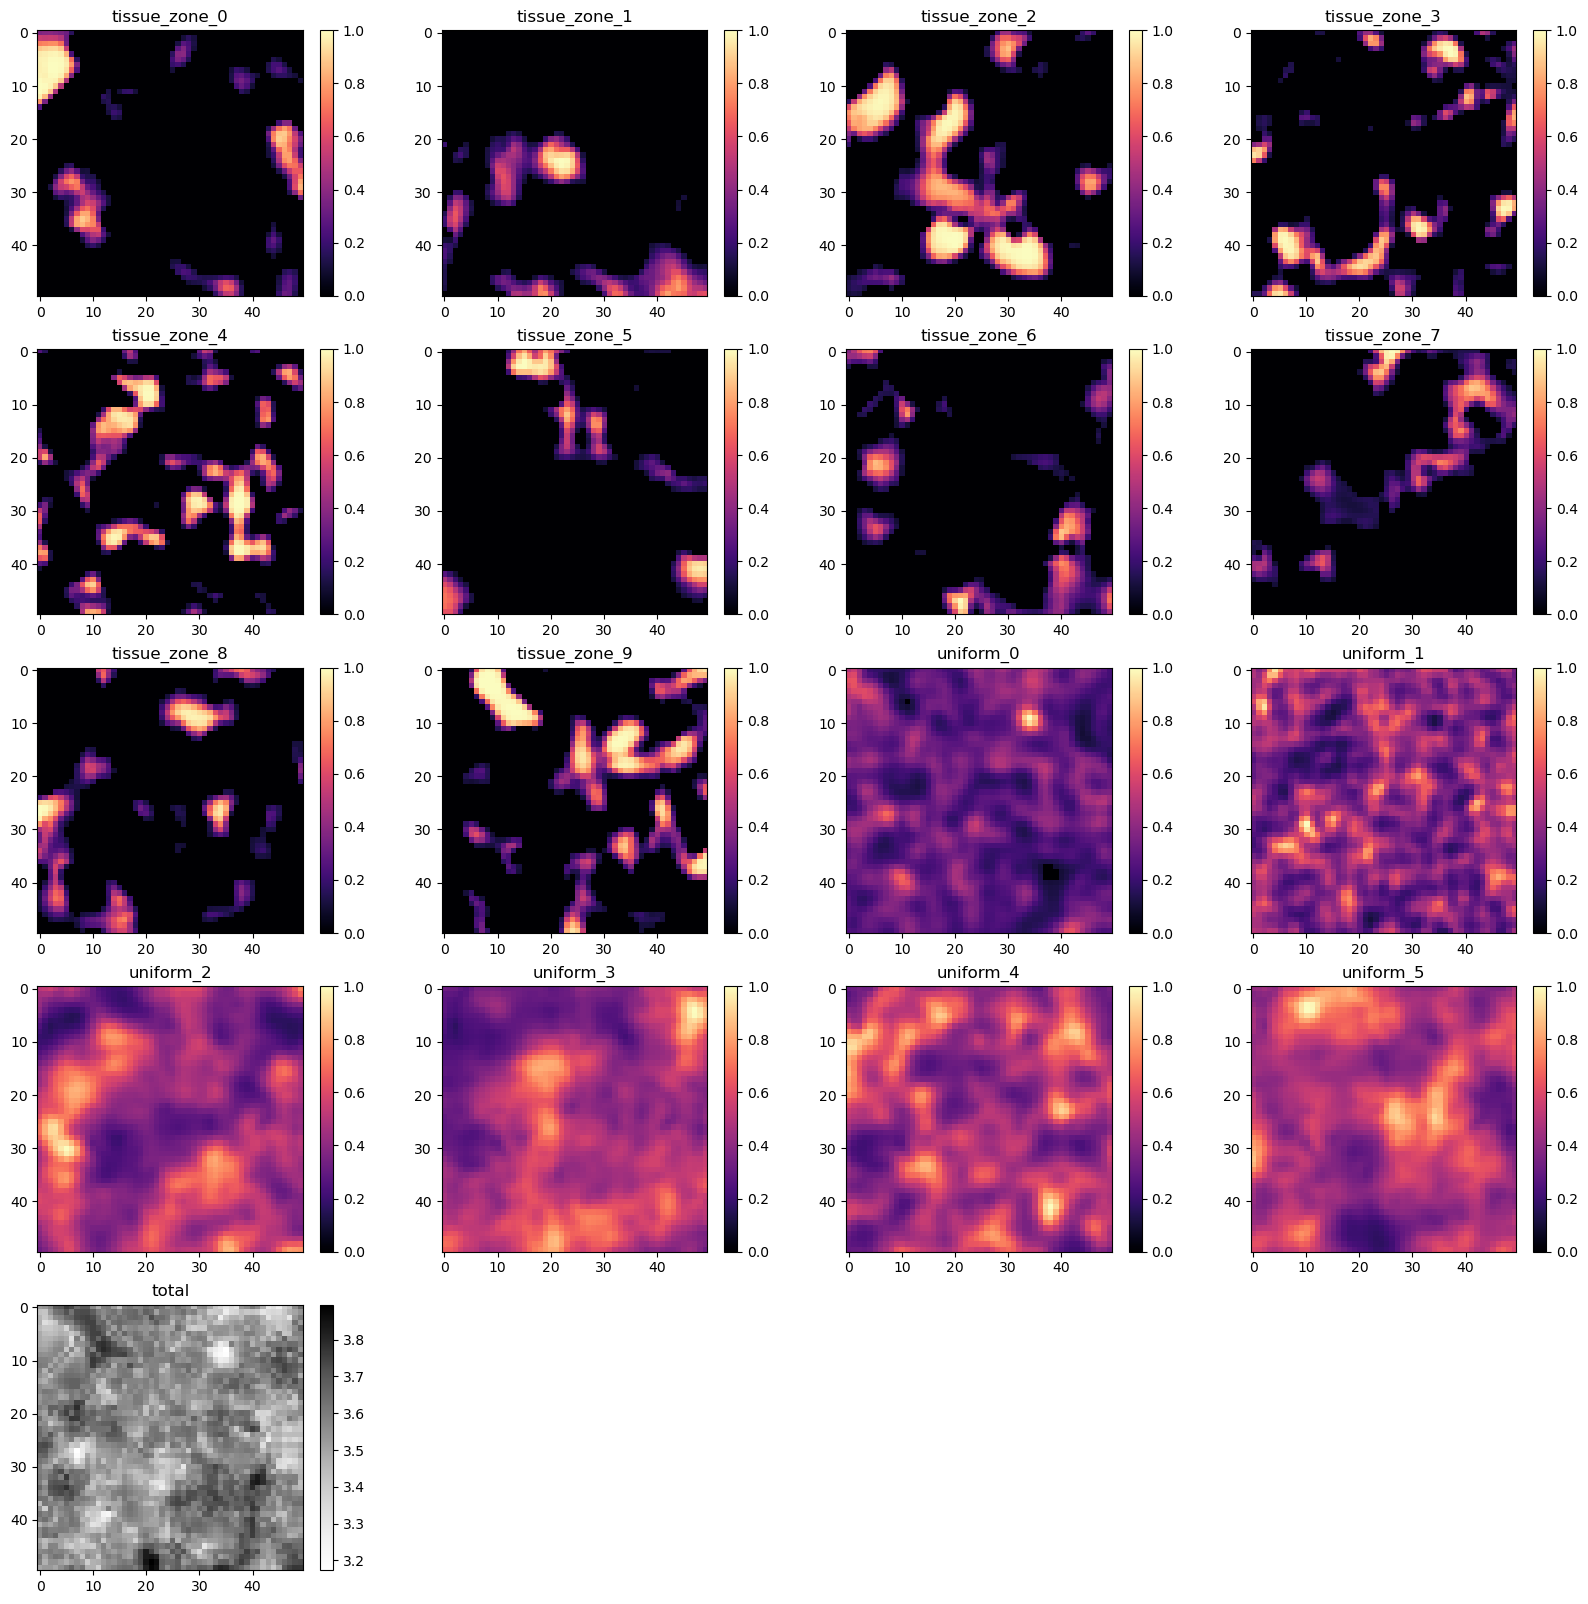

In [17]:
np.random.seed(seed)
# Sample bw parameter
mean_var_ratio = 1.2
mean = 8
tissue_zones_l1_true = np.random.gamma(mean * mean_var_ratio, 1 / mean_var_ratio, 
                                       size=(n_tissue_zones))
uniform_cell_types_l1_true = np.random.gamma(mean * mean_var_ratio, 1 / mean_var_ratio, 
                                             size=(len(uniform_cell_types)))
def sample_GP(locations, x1, x2):
    # Sample abundances with GP
    sparse_abundances = random_GP(X=locations, x1=x1, x2=x2, n_variables=n_tissue_zones, 
                                                    eta_true=1.5,
                                                    l1_true=tissue_zones_l1_true,
                                                    l2_true=tissue_zones_l1_true)
    sparse_abundances = sparse_abundances / sparse_abundances.max(0)
    sparse_abundances[sparse_abundances < 0.1] = 0

    uniform_abundances = random_GP(X=locations, x1=x1, x2=x2, n_variables=len(uniform_cell_types), 
                                                      eta_true=0.5,
                                                    l1_true=uniform_cell_types_l1_true,
                                                    l2_true=uniform_cell_types_l1_true)
    uniform_abundances = uniform_abundances / uniform_abundances.max(0)
    uniform_abundances[uniform_abundances < 0.1] = 0

    abundances = np.concatenate([sparse_abundances, uniform_abundances], axis=1)
    return pd.DataFrame(abundances, 
                                 index=[f'location_{i}' for i in range(abundances.shape[0])],
                                 columns=cell_types2zones.columns
                                )

locations_1, x1, x2 = generate_grid(n=n_locations)
locations = np.concatenate([locations_1 for _ in range(n_experiments)], axis=0)

abundances_df = pd.DataFrame()

for e in range(n_experiments):
    
    abundances_df_1 = sample_GP(locations_1, x1, x2)
    abundances_df_1.index = [f'exper{e}_{l}' for l in abundances_df_1.index]
    abundances_df = pd.concat((abundances_df, abundances_df_1), axis=0)
    
    plt.figure(figsize=(3*5+5,3*5+5))
    plot_spatial(abundances_df_1.values, n=n_locations, nrows=5, names=abundances_df.columns)
    plt.show()

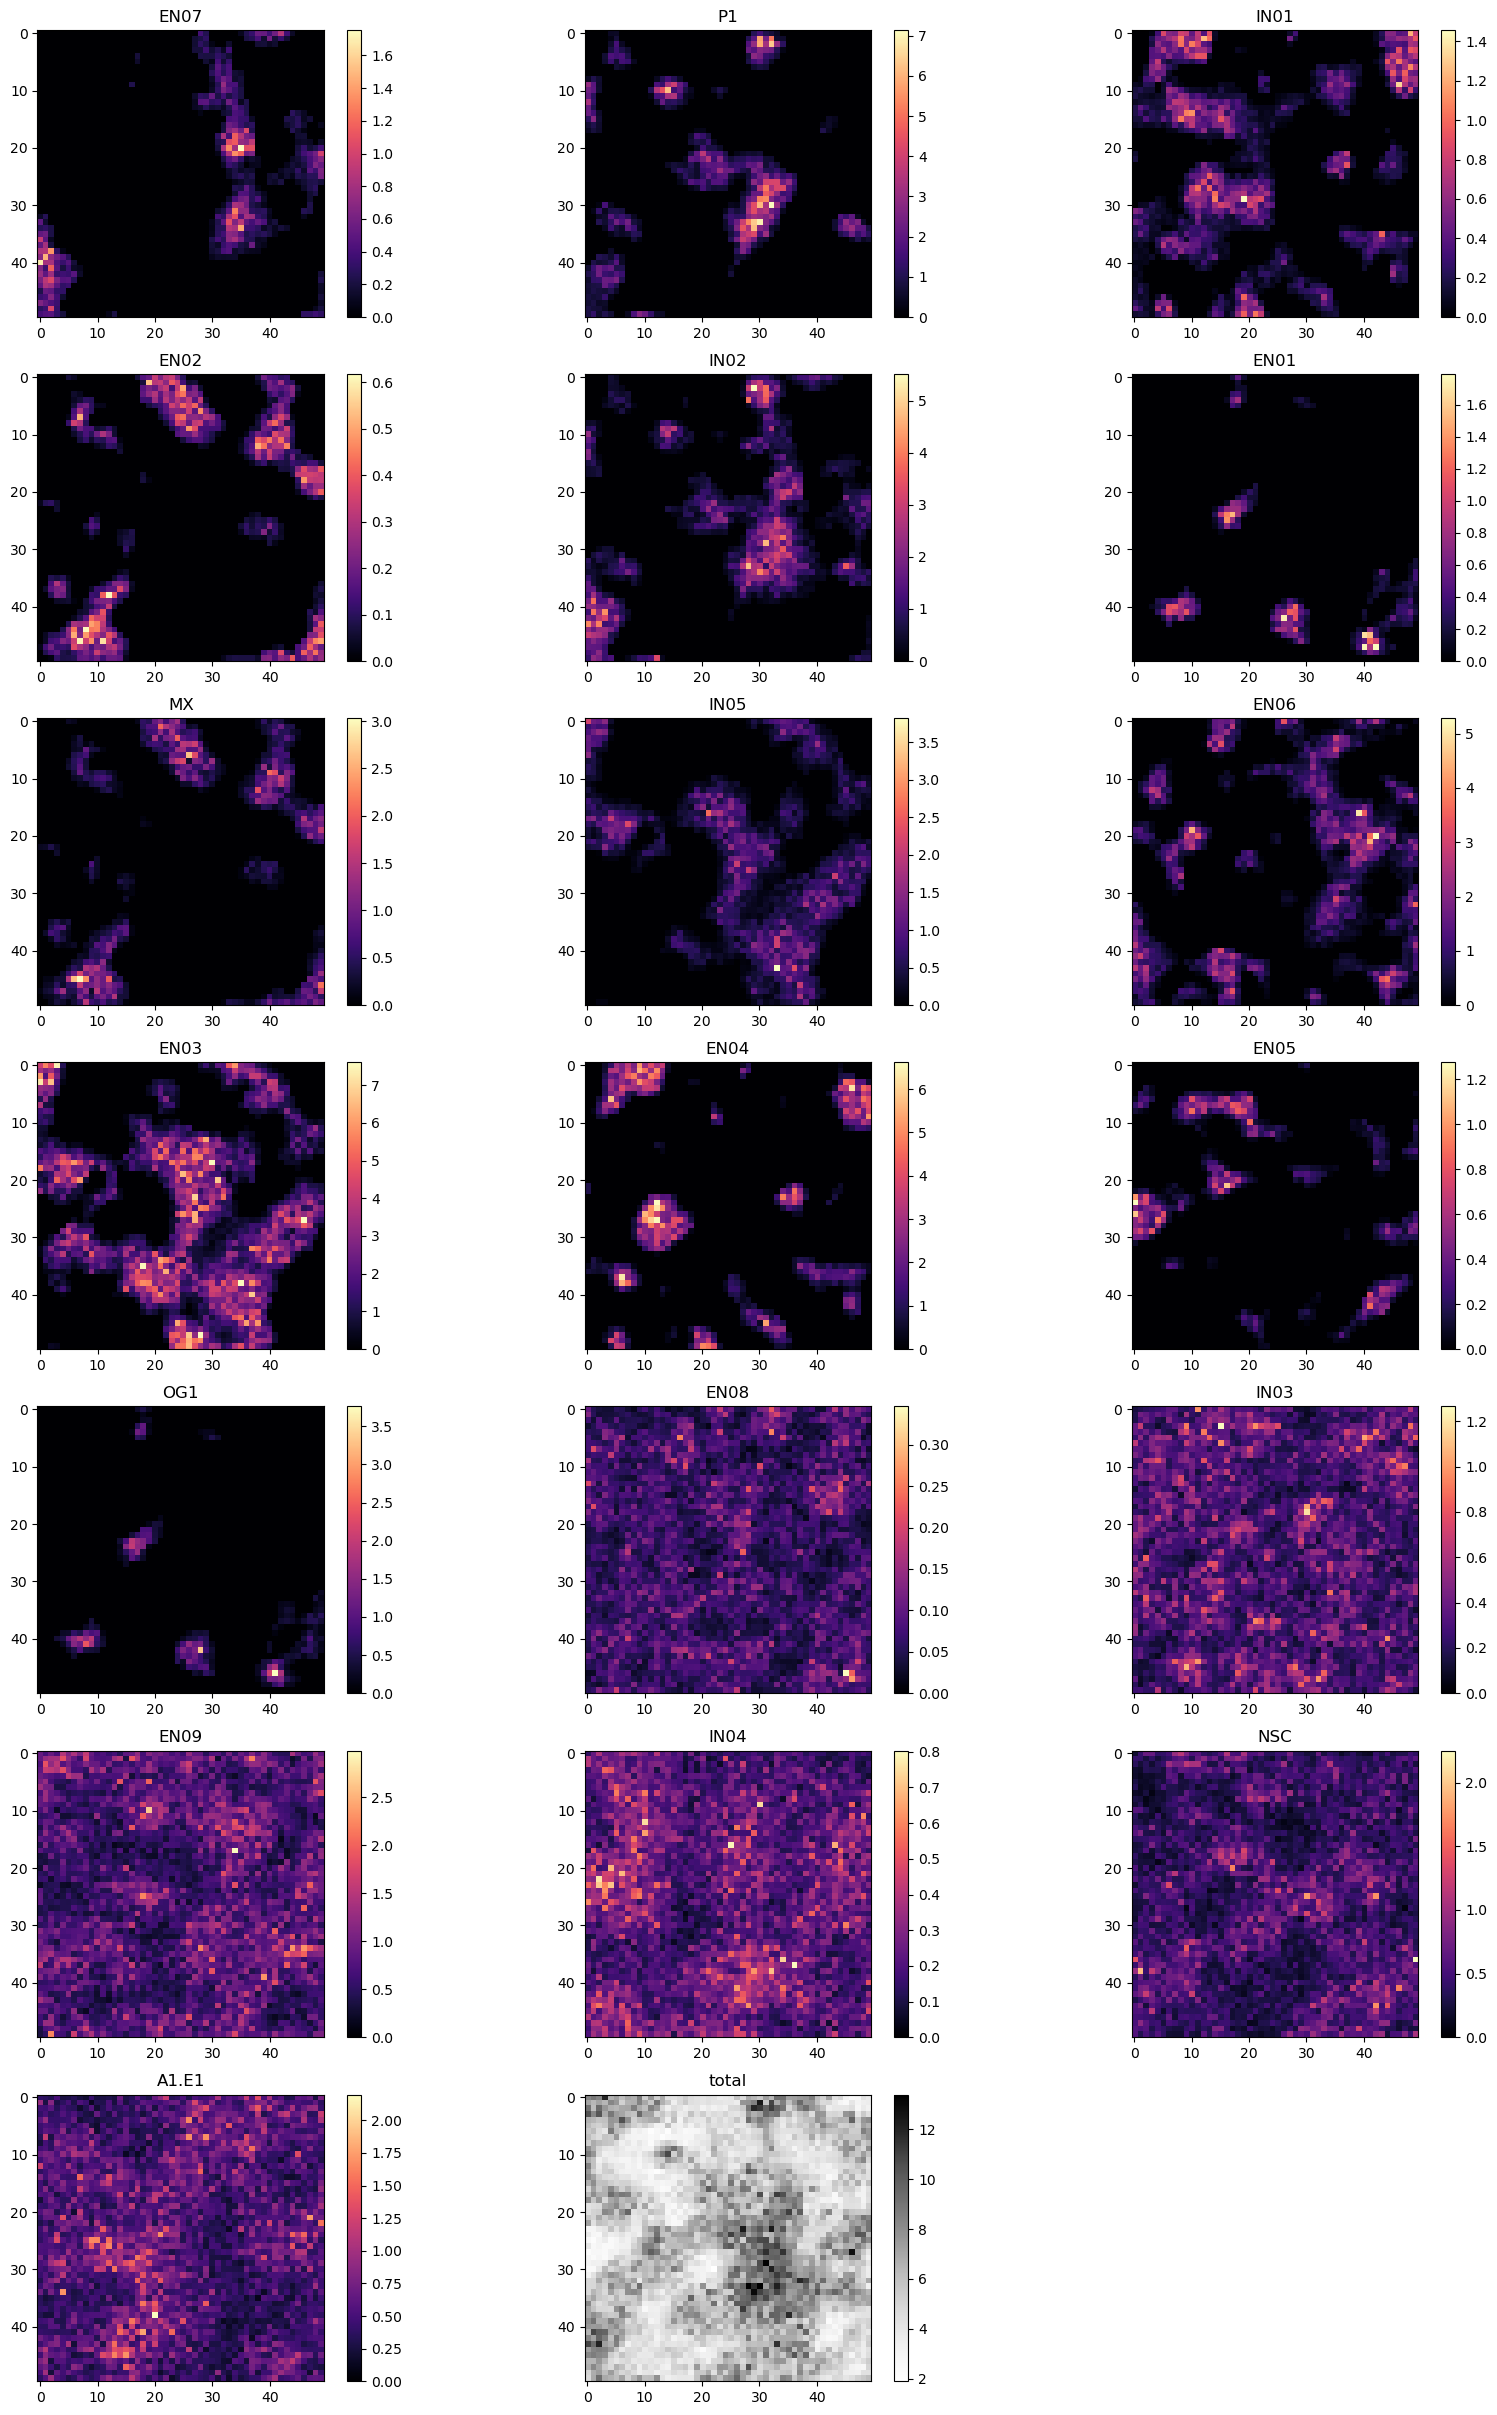

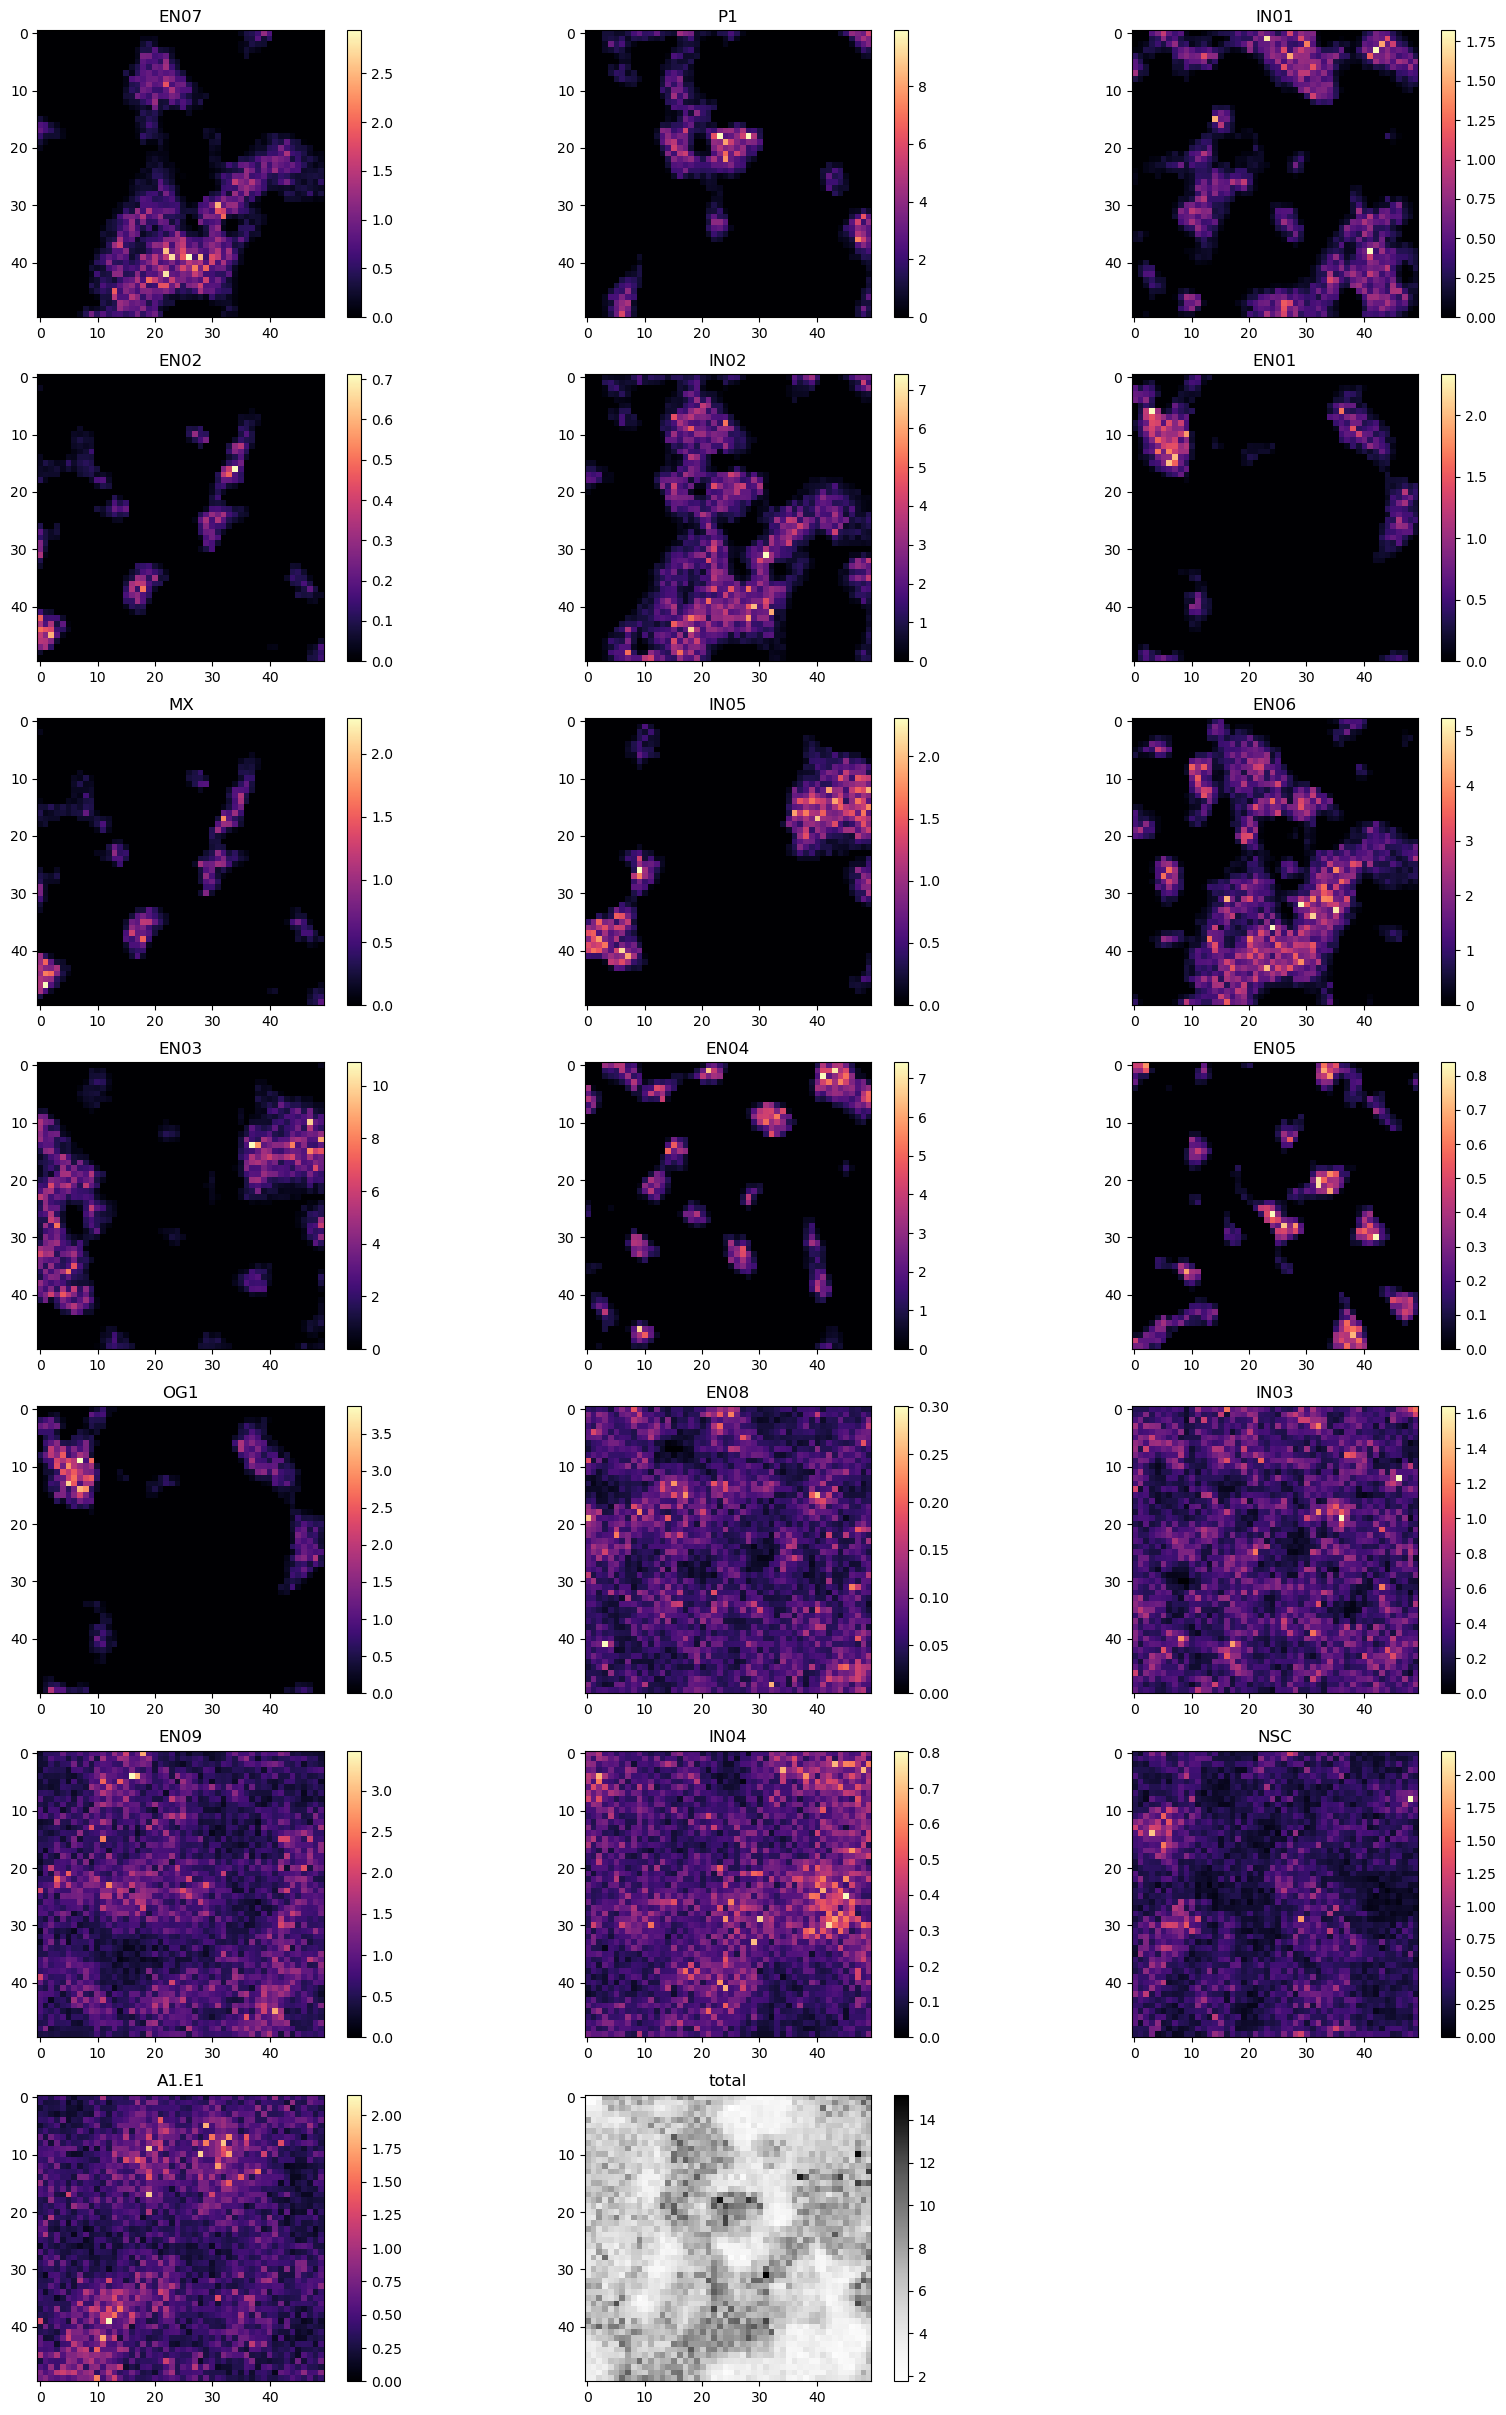

In [18]:
np.random.seed(seed)
cell_abundances = np.dot(abundances_df, cell_types2zones.T)
cell_abundances = cell_abundances * np.random.lognormal(0, 0.35, size=cell_abundances.shape)
cell_abundances_df = pd.DataFrame(cell_abundances, 
                             index=abundances_df.index,
                             columns=cell_types2zones.index
                            )
# Plots just the first two experiments
plt.figure(figsize=(3*5+5, 3*10+5))
plot_spatial(cell_abundances_df.values[experiment_id==0,:], 
             n=n_locations, nrows=8, 
             names=cell_abundances_df.columns, vmax=None)
plt.show()
plt.figure(figsize=(3*5+5, 3*10+5))
plot_spatial(cell_abundances_df.values[experiment_id==1,:], 
             n=n_locations, nrows=8, 
             names=cell_abundances_df.columns, vmax=None)
plt.show()

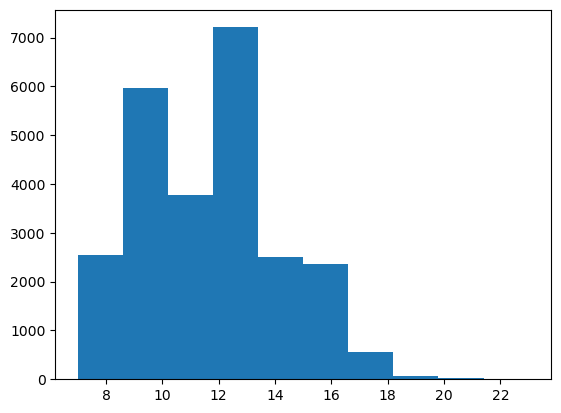

EN07      5288.0
P1       11341.0
IN01      9738.0
EN02      6182.0
IN02     15821.0
EN01      5984.0
MX        7212.0
IN05      6827.0
EN06     14931.0
EN03     26191.0
EN04     12302.0
EN05      5385.0
OG1       7103.0
EN08     24987.0
IN03     25152.0
EN09     29155.0
IN04     25005.0
NSC      25701.0
A1.E1    26077.0
dtype: float64

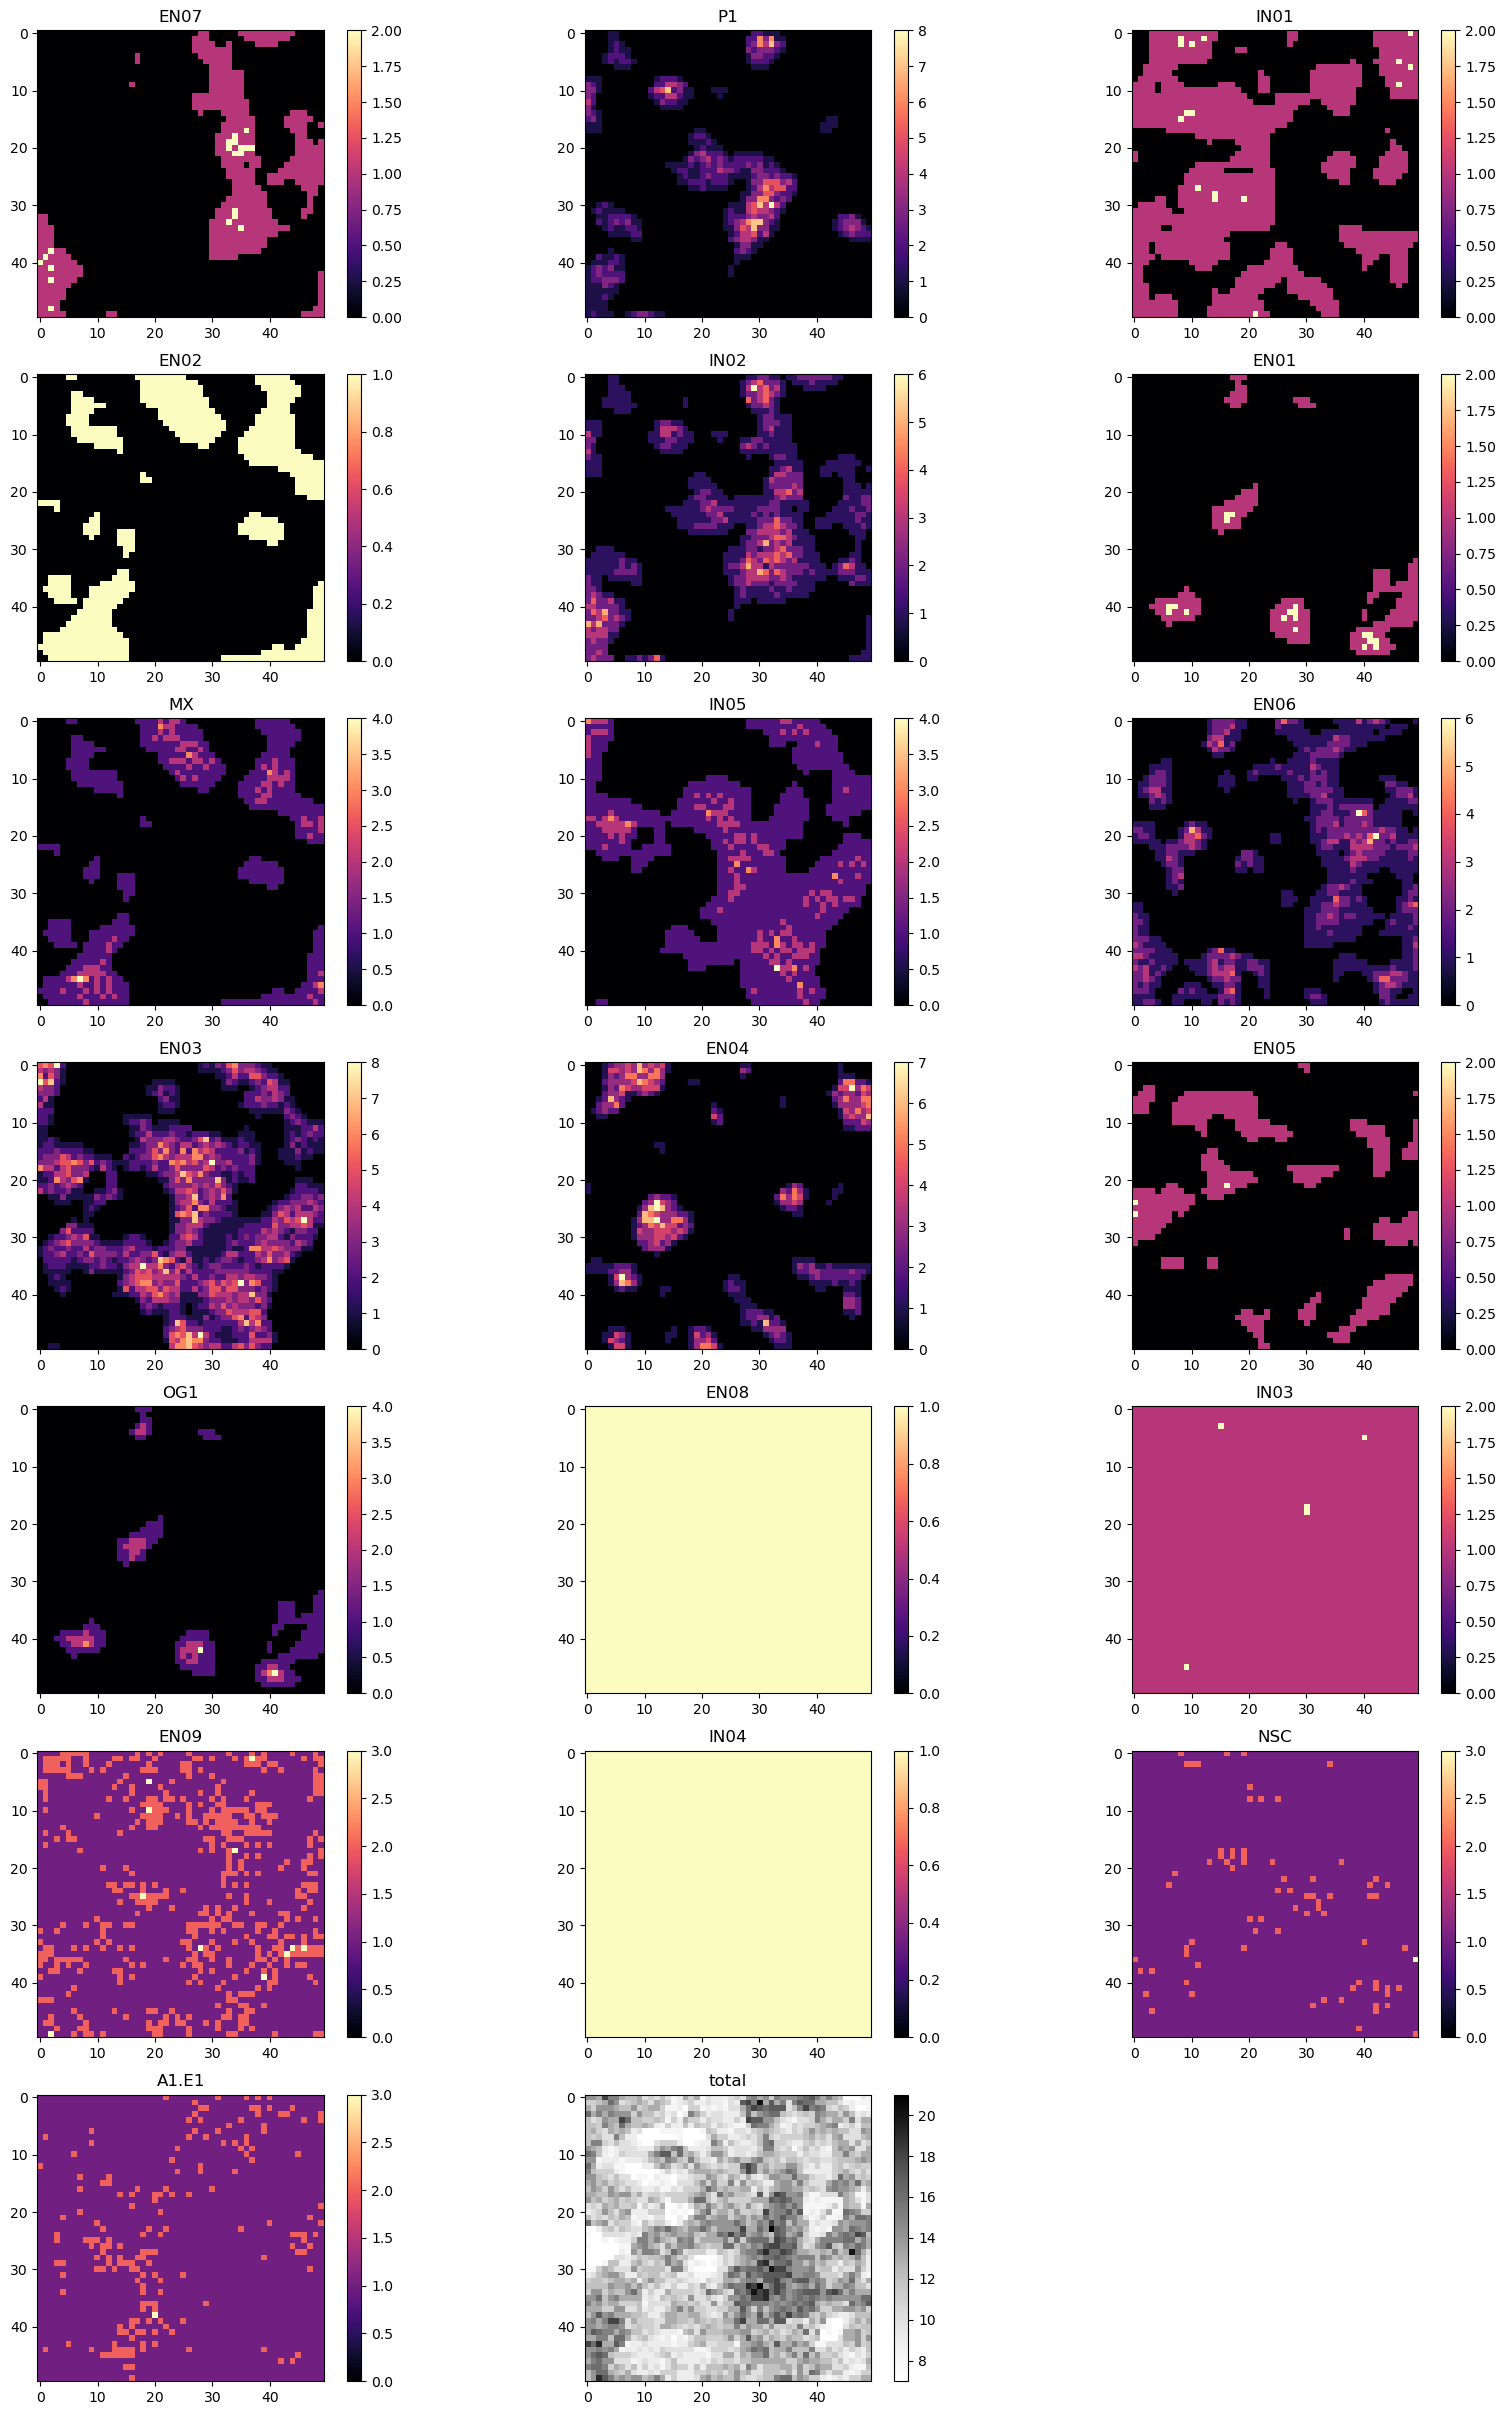

In [19]:
cell_count_df = np.ceil(cell_abundances_df)
plt.hist(cell_count_df.sum(1));
plt.show();

plt.figure(figsize=(3*5+5, 3*10+5))
plot_spatial(cell_count_df.values[experiment_id==0,:], 
             n=n_locations, nrows=8, 
             names=cell_count_df.columns, vmax=None)

cell_count_df.sum(0)

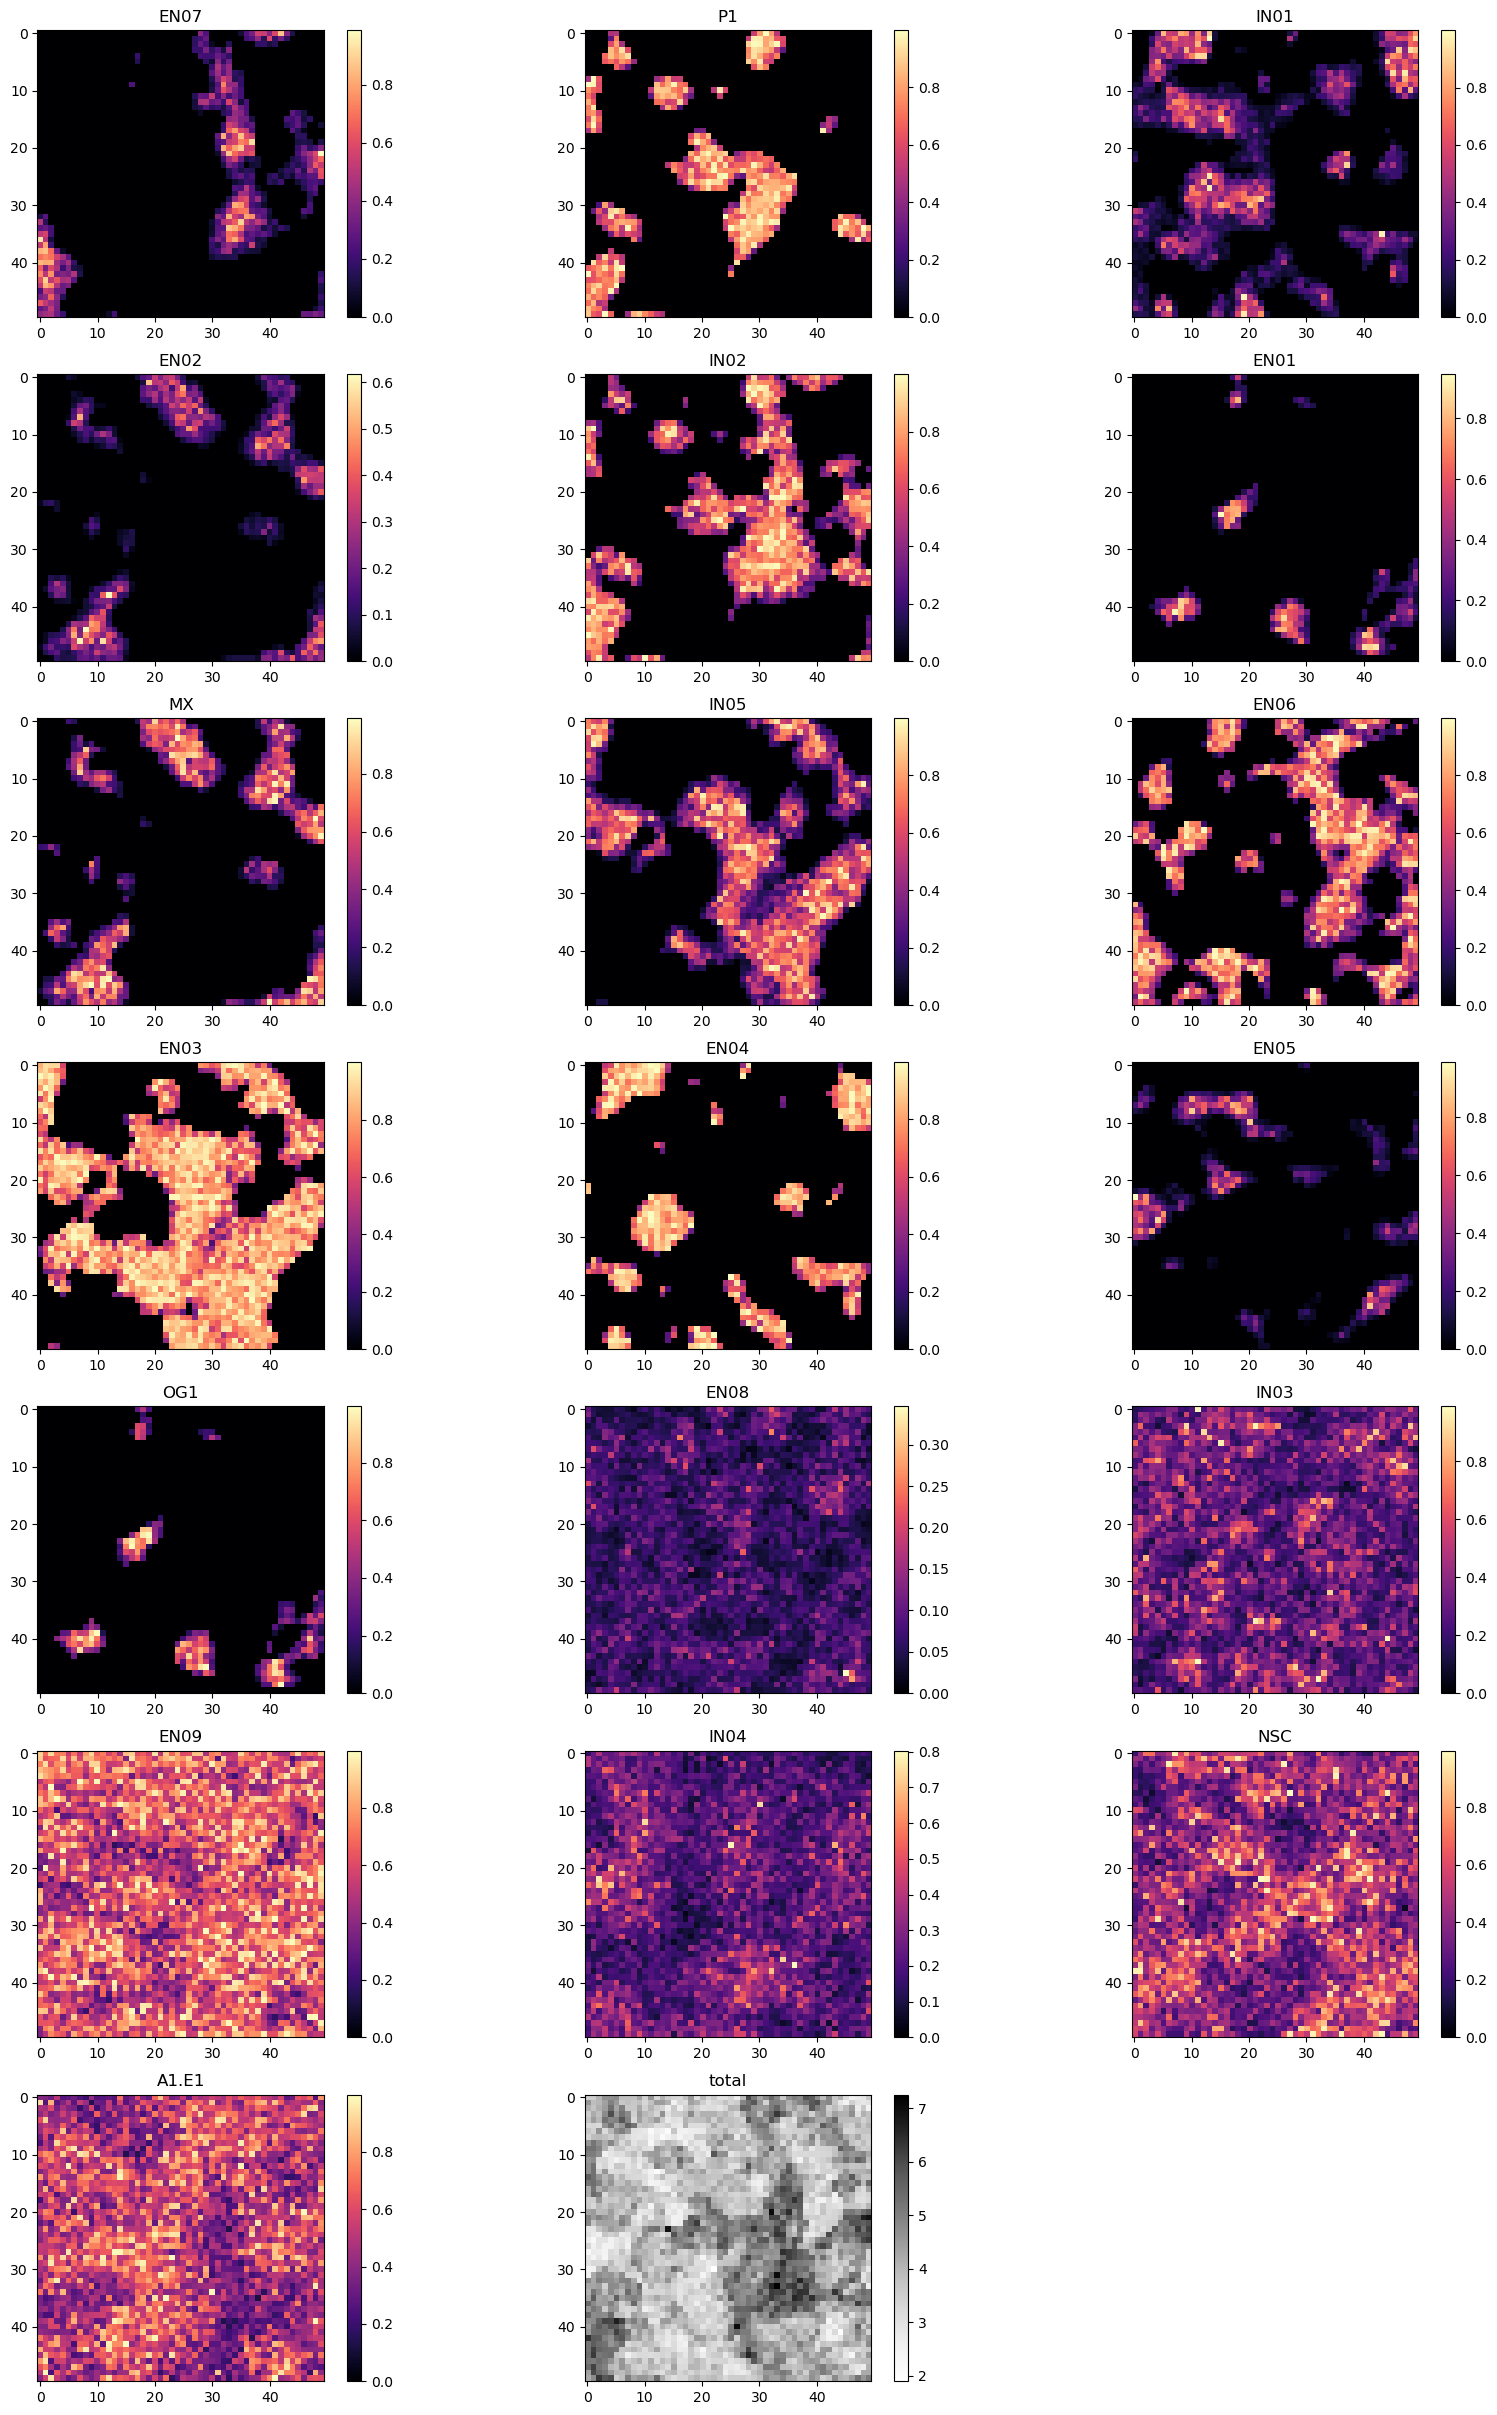

In [20]:
cell_capture_eff_df = cell_abundances_df / cell_count_df
cell_capture_eff_df[cell_capture_eff_df.isna()] = 0

plt.figure(figsize=(3*5+5, 3*10+5))
plot_spatial(cell_capture_eff_df.values[experiment_id==0,:], 
             n=n_locations, nrows=8, 
             names=cell_capture_eff_df.columns, vmax=None)

In [21]:
cell_count_df

EN07   P1  IN01  EN02  IN02  EN01   MX  IN05  EN06  \
exper0_location_0      0.0  0.0   0.0   0.0   0.0   0.0  0.0   3.0   0.0   
exper0_location_1      0.0  0.0   0.0   0.0   0.0   0.0  0.0   1.0   0.0   
exper0_location_2      0.0  0.0   0.0   0.0   0.0   0.0  0.0   1.0   0.0   
exper0_location_3      0.0  0.0   0.0   0.0   0.0   0.0  0.0   2.0   0.0   
exper0_location_4      0.0  0.0   0.0   0.0   0.0   0.0  0.0   2.0   0.0   
...                    ...  ...   ...   ...   ...   ...  ...   ...   ...   
exper9_location_2495   1.0  0.0   0.0   0.0   2.0   1.0  0.0   2.0   2.0   
exper9_location_2496   1.0  0.0   0.0   0.0   1.0   1.0  0.0   1.0   1.0   
exper9_location_2497   0.0  0.0   0.0   0.0   0.0   1.0  0.0   1.0   0.0   
exper9_location_2498   0.0  0.0   0.0   0.0   0.0   1.0  0.0   1.0   0.0   
exper9_location_2499   0.0  0.0   0.0   0.0   0.0   1.0  0.0   1.0   0.0   

                      EN03  EN04  EN05  OG1  EN08  IN03  EN09  IN04  NSC  \
exper0_location_0      5.0   0.0   0.0  0.0   1.0   1.0   1.0   1.0  1.0   
exper0_location_1      4.0   0.0   0.0  0.0   1.0   1.0   1.0   1.0  1.0   
exper0_location_2      6.0   0.0   0.0  0.0   1.0   1.0   1.0   1.0  1.0   
exper0_location_3      8.0   0.0   0.0  0.0   1.0   1.0   1.0   1.0  1.0   
exper0_location_4      4.0   0.0   0.0  0.0   1.0   1.0   1.0   1.0  1.0   
...                    ...   ...   ...  ...   ...   ...   ...   ...  ...   
exper9_location_2495   3.0   0.0   0.0  1.0   1.0   1.0   1.0   1.0  1.0   
exper9_location_2496   4.0   0.0   0.0  1.0   1.0   1.0   1.0   1.0  1.0   
exper9_location_2497   4.0   0.0   0.0  1.0   1.0   1.0   1.0   1.0  1.0   
exper9_location_2498   4.0   0.0   0.0  2.0   1.0   1.0   1.0   1.0  1.0   
exper9_location_2499   1.0   0.0   0.0  1.0   1.0   1.0   1.0   1.0  1.0   

                      A1.E1  
exper0_location_0       1.0  
exper0_location_1       1.0  
exper0_location_2       1.0  
exper0_location_3       1.0  
exper0_location_4       1.0  
...                     ...  
exper9_location_2495    1.0  
exper9_location_2496    1.0  
exper9_location_2497    1.0  
exper9_location_2498    1.0  
exper9_location_2499    1.0  

[25000 rows x 19 columns]

In [22]:
cell_capture_eff_df

EN07   P1  IN01  EN02      IN02      EN01   MX  \
exper0_location_0     0.000000  0.0   0.0   0.0  0.000000  0.000000  0.0   
exper0_location_1     0.000000  0.0   0.0   0.0  0.000000  0.000000  0.0   
exper0_location_2     0.000000  0.0   0.0   0.0  0.000000  0.000000  0.0   
exper0_location_3     0.000000  0.0   0.0   0.0  0.000000  0.000000  0.0   
exper0_location_4     0.000000  0.0   0.0   0.0  0.000000  0.000000  0.0   
...                        ...  ...   ...   ...       ...       ...  ...   
exper9_location_2495  0.328618  0.0   0.0   0.0  0.536310  0.231237  0.0   
exper9_location_2496  0.124667  0.0   0.0   0.0  0.162332  0.358521  0.0   
exper9_location_2497  0.000000  0.0   0.0   0.0  0.000000  0.378750  0.0   
exper9_location_2498  0.000000  0.0   0.0   0.0  0.000000  0.597715  0.0   
exper9_location_2499  0.000000  0.0   0.0   0.0  0.000000  0.489271  0.0   

                          IN05      EN06      EN03  EN04  EN05       OG1  \
exper0_location_0     0.725611  0.000000  0.833865   0.0   0.0  0.000000   
exper0_location_1     0.744437  0.000000  0.864316   0.0   0.0  0.000000   
exper0_location_2     0.916946  0.000000  0.994186   0.0   0.0  0.000000   
exper0_location_3     0.590682  0.000000  0.905901   0.0   0.0  0.000000   
exper0_location_4     0.554489  0.000000  0.786814   0.0   0.0  0.000000   
...                        ...       ...       ...   ...   ...       ...   
exper9_location_2495  0.614850  0.513664  0.920574   0.0   0.0  0.253409   
exper9_location_2496  0.566893  0.563610  0.772541   0.0   0.0  0.435159   
exper9_location_2497  0.472289  0.000000  0.881469   0.0   0.0  0.844239   
exper9_location_2498  0.714715  0.000000  0.755750   0.0   0.0  0.524158   
exper9_location_2499  0.432444  0.000000  0.986066   0.0   0.0  0.958842   

                          EN08      IN03      EN09      IN04       NSC  \
exper0_location_0     0.103980  0.145452  0.915126  0.140706  0.199098   
exper0_location_1     0.129181  0.171426  0.888646  0.390280  0.426347   
exper0_location_2     0.073214  0.166582  0.740492  0.399806  0.363389   
exper0_location_3     0.031612  0.372683  0.860996  0.154093  0.197110   
exper0_location_4     0.055797  0.366376  0.937201  0.211047  0.191732   
...                        ...       ...       ...       ...       ...   
exper9_location_2495  0.068643  0.670991  0.392946  0.324881  0.513069   
exper9_location_2496  0.062627  0.748275  0.335920  0.148403  0.245594   
exper9_location_2497  0.071174  0.410708  0.802340  0.181680  0.585711   
exper9_location_2498  0.041377  0.365143  0.361269  0.171103  0.324394   
exper9_location_2499  0.066370  0.182268  0.850009  0.159268  0.238540   

                         A1.E1  
exper0_location_0     0.389906  
exper0_location_1     0.940758  
exper0_location_2     0.476093  
exper0_location_3     0.402755  
exper0_location_4     0.614773  
...                        ...  
exper9_location_2495  0.378225  
exper9_location_2496  0.261647  
exper9_location_2497  0.408756  
exper9_location_2498  0.800266  
exper9_location_2499  0.734080  

[25000 rows x 19 columns]

In [23]:

# Save simulated spatial data to matrices. The data is in theree parts:
cell_count_df.to_csv(f'{sp_data_folder}cell_count_df_{date}.csv')
cell_capture_eff_df.to_csv(f'{sp_data_folder}cell_capture_eff_df_{date}.csv')
cell_abundances_df.to_csv(f'{sp_data_folder}cell_abundances_df_{date}.csv')

In [25]:
gp_bw = pd.DataFrame(np.concatenate((tissue_zones_l1_true, uniform_cell_types_l1_true)),
                     index=cell_types2zones.columns, columns=['GP_bandwidth'])
gp_bw.to_csv(f'{sp_data_folder}gp_bw_{date}.csv')
cell_types2zones['is_uniform'] = 0
cell_types2zones['is_uniform'][uniform_cell_types] = 1
cell_types2zones['is_high_density'] = 0
cell_types2zones['is_high_density'][high_density_cell_types] = 1
cell_types2zones.to_csv(f'{sp_data_folder}cell_types2zones_{date}.csv')

In [26]:
# Sample cell indices
np.random.seed(seed)

from scipy.sparse import csr_matrix

# create generation set
generation_rna = rna.copy()
# add index to each cell
generation_rna.obs['cell_ind'] = np.arange(rna.shape[0])

def sample_cell_indices(generation_rna, cell_count_df, cell_capture_eff_df):
    from scipy.sparse import csr_matrix
    locations2cells = np.zeros((cell_count_df.shape[0], generation_rna.shape[0]))
    for i, l in enumerate(cell_count_df.index):
        for j, ct in enumerate(cell_count_df.columns):
            cell_ind_all = generation_rna.obs['cell_ind']
            cell_ind_all = cell_ind_all[generation_rna.obs['celltype'] == ct]
            cell_ind = np.random.choice(cell_ind_all, int(cell_count_df.loc[l, ct]), replace=False)
            locations2cells[i,cell_ind] = cell_capture_eff_df.loc[l, ct]

    return csr_matrix(locations2cells)
    
locations2cells = sample_cell_indices(generation_rna, cell_count_df, cell_capture_eff_df)

In [27]:
# Compute synthetic counts
synthetic_counts = locations2cells.dot(generation_rna.X)

# Create adata object
synth_adata = ad.AnnData(synthetic_counts)
synth_adata.obs_names = cell_count_df.index
synth_adata.var_names = generation_rna.var_names
synth_adata.obs[[f'cell_count_{ct}' for ct in cell_count_df.columns]] = cell_count_df
synth_adata.obs[[f'cell_abundances_{ct}' for ct in cell_abundances_df.columns]] = cell_abundances_df
synth_adata.obs[[f'cell_capture_eff_{ct}' for ct in cell_capture_eff_df.columns]] = cell_capture_eff_df
synth_adata.obsm['X_spatial'] = locations
synth_adata.uns['design'] = {'cell_types2zones': cell_types2zones,
                             'gp_bw': gp_bw}
from re import sub
synth_adata.obs['sample'] = [sub('_location.+$','',i) for i in synth_adata.obs_names]

synth_adata.shape

(25000, 21127)

In [28]:
# compute synthetic counts per cell type
for j, ct in enumerate(cell_count_df.columns):
    locations2cells_ct = sample_cell_indices(generation_rna, cell_count_df[[ct]], cell_capture_eff_df)
    synthetic_counts_ct = locations2cells_ct.dot(generation_rna.X)
    synth_adata.obs[f'UMI_count_{ct}'] = np.array(synthetic_counts_ct.sum(1)).flatten()

In [29]:
gene_level_df.index

Index(['Gnai3', 'Narf', 'Klf6', 'Scmh1', 'Cox5a', 'Wnt9a', 'Fer', 'Xpo6',
       'Tfe3', 'Axin2',
       ...
       'AC154782.1', 'AC118542.1', 'AC129328.1', 'AC166832.3', 'AC138306.1',
       'AC165953.2', 'AC110241.2', 'AC161607.1', 'Atp5o', '9030025P20Rik'],
      dtype='object', name='Gene', length=12809)

In [30]:
backup_gldf = gene_level_df
synth_backup = synth_adata

In [31]:
# Match genes and remove duplicates
common_genes = synth_adata.var_names.intersection(gene_level_df.index)

synth_adata = synth_adata[:,synth_adata.var.index.isin(common_genes)]
gene_level_df = gene_level_df[gene_level_df.index.isin(common_genes)]

synth_adata = synth_adata[:,~synth_adata.var.index.duplicated()]
gene_level_df = gene_level_df[~gene_level_df.index.duplicated()]

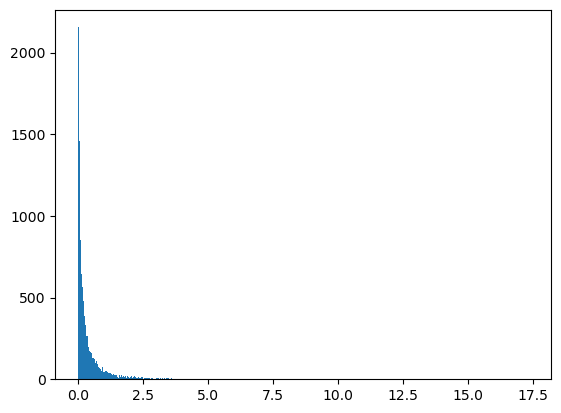

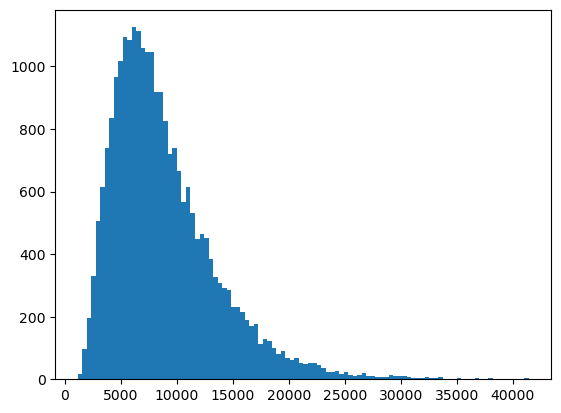

In [32]:
np.random.seed(seed)
# Use observed detection rates
synth_adata_obs_mg = synth_adata[:,synth_adata.var.index.isin(gene_level_df.index)].copy() #Updated
gene_level_df = gene_level_df[gene_level_df.index.isin(synth_adata_obs_mg.var.index)]
plt.hist(gene_level_df.values.flatten(), bins=500);
plt.show()

synth_adata_obs_mg.var['gene_level'] = gene_level_df.values.flatten()
synth_adata_obs_mg.X = synth_adata_obs_mg.X * gene_level_df.values.T

# Sample poisson integers
synth_adata_obs_mg.layers['expression_levels'] = synth_adata_obs_mg.X
synth_adata_obs_mg.X = csr_matrix(np.random.poisson(synth_adata_obs_mg.X))
gene_level_df.values.mean()

# save resulting anndata
synth_adata_obs_mg.write(f'{sp_data_folder}synth_adata_real_mg_{date}.h5ad')

plt.hist(np.array(synth_adata_obs_mg.X.sum(1)).flatten(), bins=100);
plt.show()

In [33]:
synth_adata_obs_mg

AnnData object with n_obs × n_vars = 25000 × 11777
    obs: 'cell_count_EN07', 'cell_count_P1', 'cell_count_IN01', 'cell_count_EN02', 'cell_count_IN02', 'cell_count_EN01', 'cell_count_MX', 'cell_count_IN05', 'cell_count_EN06', 'cell_count_EN03', 'cell_count_EN04', 'cell_count_EN05', 'cell_count_OG1', 'cell_count_EN08', 'cell_count_IN03', 'cell_count_EN09', 'cell_count_IN04', 'cell_count_NSC', 'cell_count_A1.E1', 'cell_abundances_EN07', 'cell_abundances_P1', 'cell_abundances_IN01', 'cell_abundances_EN02', 'cell_abundances_IN02', 'cell_abundances_EN01', 'cell_abundances_MX', 'cell_abundances_IN05', 'cell_abundances_EN06', 'cell_abundances_EN03', 'cell_abundances_EN04', 'cell_abundances_EN05', 'cell_abundances_OG1', 'cell_abundances_EN08', 'cell_abundances_IN03', 'cell_abundances_EN09', 'cell_abundances_IN04', 'cell_abundances_NSC', 'cell_abundances_A1.E1', 'cell_capture_eff_EN07', 'cell_capture_eff_P1', 'cell_capture_eff_IN01', 'cell_capture_eff_EN02', 'cell_capture_eff_IN02', 'cell_capt

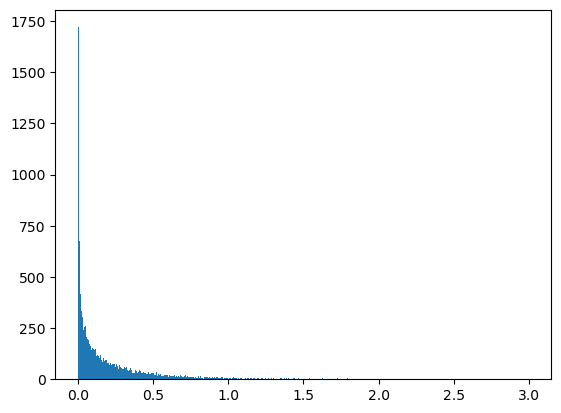

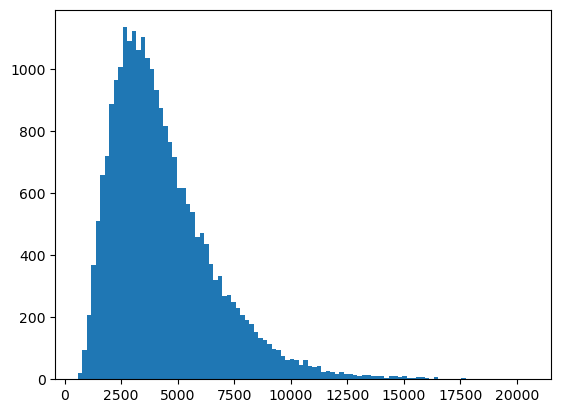

In [34]:
np.random.seed(seed)
# Sample detection rates
gene_level = np.random.gamma(shape=posterior.posterior['gene_level_alpha_hyp'].mean(), 
                             scale=1/posterior.posterior['gene_level_beta_hyp'].mean(), 
                             size=(1, synth_adata.shape[1])) / 2
plt.hist(gene_level.flatten(), bins=500);
plt.show()

synth_adata.var['gene_level'] = gene_level.flatten()
synth_adata.X = synth_adata.X * gene_level

# Sample poisson integers
synth_adata.layers['expression_levels'] = synth_adata.X
synth_adata.X = np.random.poisson(synth_adata.X)
synth_adata.X = csr_matrix(synth_adata.X)
gene_level.mean()

# save resulting anndata
synth_adata.write(f'{sp_data_folder}synth_adata_random_mg_{date}.h5ad')

plt.hist(np.array(synth_adata.X.sum(1)).flatten(), bins=100);
plt.show()

In [35]:
np.random.seed(seed)

synth_adata_contam = synth_adata.copy()

# sample contamination
contamination_average = synth_adata.X.mean(0)

mu_contamination = 0.03
mean_var_ratio=150
per_experiment_proportion = np.random.gamma(mu_contamination * mean_var_ratio, 
                                            1/mean_var_ratio, 
                                            size=(n_experiments, 1))

average_contamination = per_experiment_proportion * contamination_average
cell2sample_df = pd.get_dummies(synth_adata.obs['sample'])
per_loc_average_contamination = np.dot(cell2sample_df.values, average_contamination)

# add contamination counts
contamination = csr_matrix(np.random.poisson(per_loc_average_contamination))
synth_adata_contam.layers['contamination'] = contamination
synth_adata_contam.X = synth_adata_contam.X + contamination

# save resulting anndata
synth_adata_contam.write(f'{sp_data_folder}synth_adata_contamination_{date}.h5ad')

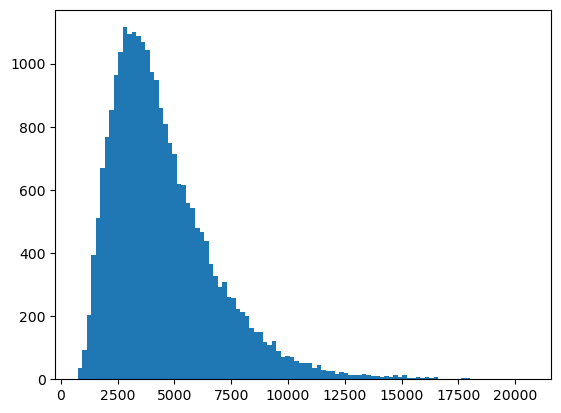

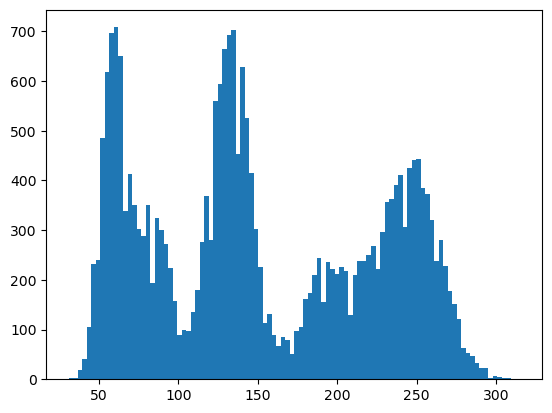

In [36]:
plt.hist(np.array(synth_adata_contam.X.sum(1)).flatten(), bins=100);
plt.show();
plt.hist(np.array(synth_adata_contam.layers['contamination'].sum(1)).flatten(), bins=100);
plt.show();

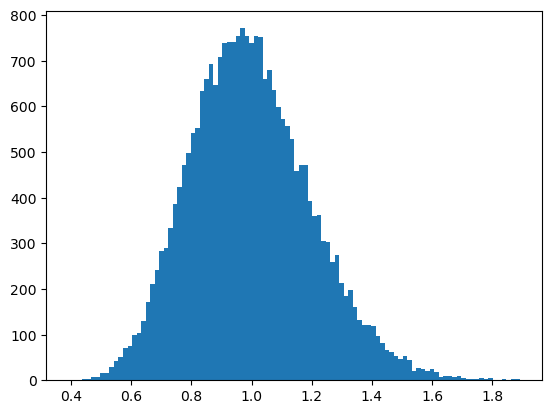

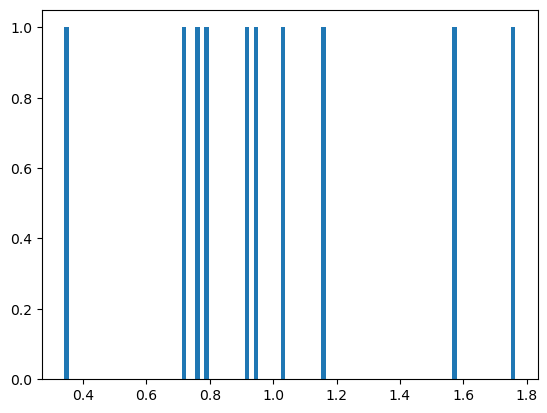

In [37]:
np.random.seed(seed)

synth_adata_contam_depth = synth_adata.copy()

# sample contamination
contamination_average = synth_adata.X.mean(0)

mu_contamination = 0.03
mean_var_ratio=150
per_experiment_proportion = np.random.gamma(mu_contamination * mean_var_ratio, 
                                            1/mean_var_ratio, 
                                            size=(n_experiments, 1))

average_contamination = per_experiment_proportion * contamination_average
cell2sample_df = pd.get_dummies(synth_adata.obs['sample'])
per_loc_average_contamination = np.dot(cell2sample_df.values, average_contamination)

# samples per-location variability in sequencing depth
mu_depth = 1
mean_var_ratio=25
per_location_depth = np.random.gamma(mu_depth * mean_var_ratio, 
                                            1/mean_var_ratio, 
                                            size=(synth_adata.shape[0], 1))
plt.hist(np.array(per_location_depth).flatten(), bins=100);
plt.show()

# sample per-experiment variability in sequencing depth
mu_depth = 1
mean_var_ratio=5
per_experiment_depth = np.random.gamma(mu_depth * mean_var_ratio, 
                                            1/mean_var_ratio, 
                                            size=(n_experiments, 1))
plt.hist(np.array(per_experiment_depth).flatten(), bins=100);
plt.show()

# generate total sequencing depth effect
per_location_depth_total = per_location_depth * np.dot(cell2sample_df.values, per_experiment_depth)
synth_adata_contam_depth.obs['per_location_depth_total'] = np.array(per_location_depth_total).flatten()
synth_adata_contam_depth.obs['per_location_depth'] = np.array(per_location_depth).flatten()
synth_adata_contam_depth.obs['per_experiment_depth'] = np.array(np.dot(cell2sample_df.values,
                                                                       per_experiment_depth)).flatten()

# add sequencing depth effect
synth_adata_contam_depth.layers['expression_levels_depth'] \
= synth_adata_contam_depth.layers['expression_levels'] * per_location_depth_total
synth_adata_contam_depth.X = csr_matrix(np.random.poisson(synth_adata_contam_depth.layers['expression_levels_depth']))

# add contamination counts
contamination = csr_matrix(np.random.poisson(np.array(per_loc_average_contamination) * per_location_depth_total))
synth_adata_contam_depth.layers['contamination'] = contamination
synth_adata_contam_depth.X = synth_adata_contam_depth.X + contamination

# save resulting anndata
synth_adata_contam_depth.write(f'{sp_data_folder}synth_adata_contamination_depth_{date}.h5ad')

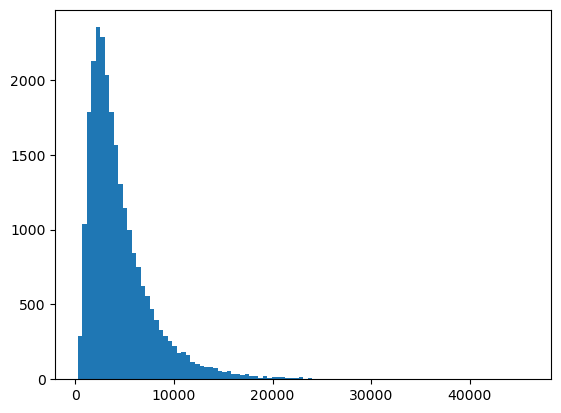

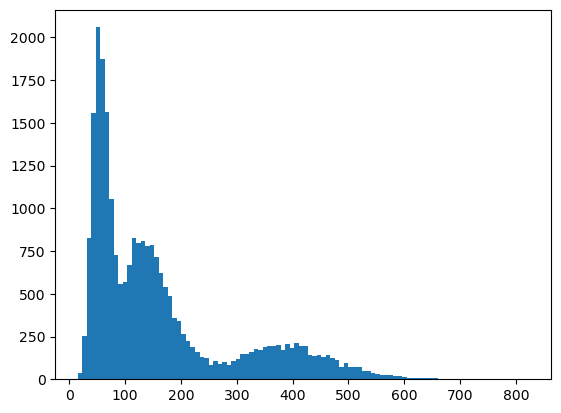

In [38]:
plt.hist(np.array(synth_adata_contam_depth.X.sum(1)).flatten(), bins=100);
plt.show();
plt.hist(np.array(synth_adata_contam_depth.layers['contamination'].sum(1)).flatten(), bins=100);
plt.show();

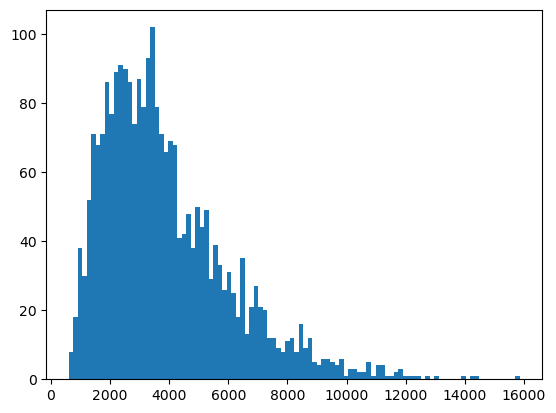

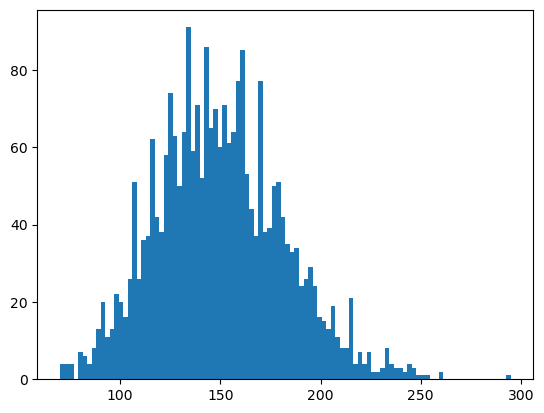

In [39]:
plt.hist(np.array(synth_adata_contam_depth[synth_adata_contam_depth.obs['sample'] == 'exper1',:].X.sum(1)).flatten(), bins=100);
plt.show();
plt.hist(np.array(synth_adata_contam_depth[synth_adata_contam_depth.obs['sample'] == 'exper1',:].layers['contamination'].sum(1)).flatten(), bins=100);
plt.show();